# Determination of OPEP Models

In [1]:
from __future__ import print_function

%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import math
import statistics
from scipy.stats import sem
from scipy import stats

from pathlib import Path

import statsmodels.api as sm

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.utils import check_consistent_length
from sklearn.utils import check_array
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

plt.style.use("seaborn-ticks") 
sns.set_context(context = "paper", font_scale = 2)

/ihome/crc/install/python/anaconda3.5-4.2.0/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Reading in the CSVs with experimental acceptor-donor pairs and DFT/sTD-DFT calculated properties with the original dataset

In [2]:
df = pd.read_csv('../data_csv/DFT_for_analysis.csv')
print("Number of acceptor-donor pairs is " + str(len(df.index)))

df_highPCE = pd.read_csv('../data_csv/DFT_for_analysis_highPCE.csv')
print("Number of acceptor-donor pairs with PCE greater than 9% is " + str(len(df_highPCE.index)))

Number of acceptor-donor pairs is 85
Number of acceptor-donor pairs with PCE greater than 9% is 60


Setting each descriptor to floats and converting into a DataFrame

In [3]:
DFTfields = {'AccHOMO': float, 'AccCalcLUMO': float, 'AccFundBg': float, 'AccOptBg': float, 'AccEnergyTransitioneV': float, 'AccTriplet': float, 
             'AccDeltaHOMO': float,'AccDeltaLUMO': float,'DeltaDipMom': float, 'GSDipMom': float,'AccEnergyTransitionWavenumber': float, 'AccOscStr': float, 
             'AccSumOscStr': float,'AccElectroIndex': float,'AccNucleoIndex':float, 'AccChemHard':float, 
             'AccElectrodonating':float, 'AccElectroaccepting':float,'PiSystemSize': float, 'Planarity': float, 'Polarizability': float,
             'DonHOMO': float, 'DonCalcLUMO': float, 'DonFundBg': float, 'DonEnergyTransitioneV': float, 'DonDeltaHOMO': float, 'DonDeltaLUMO': float,
             'DonEnergyTransitionWavenumber': float,'DonOscStr': float, 'DonSumOscStr': float,'DonElectroIndex': float, 'DonNucleoIndex': float,'DonChemHard':float,
             'DonElectrodonating':float, 'DonElectroaccepting':float,
             'AbsFOM': float,    'LUMOOffset': float, 'HOMOOffset': float, 'DHomoALumoOffset': float, 
             'acc_first_oscs': float, 'acc_highest_oscs_under_ten': float,'acc_lowest_transition_eV': float,
             'acc_lowest_transition_wavenumber': float,'don_first_oscs': float,'don_highest_oscs_under_ten': float,
             'don_lowest_transition_eV': float,'don_lowest_transition_wavenumber': float,
             'sTDDFTLUMO': float, 'sTDDFTHOMO': float, 'sTDDFTdeltaLUMO': float, 'sTDDFTdeltaHOMO': float, 'sTDDFToptbg': float, 
             'sTDDFToscs': float, 'sTDDFTfundbg': float, 'sTDDFTsinglepointenergy': float, 'sTDDFTdipolemoment': float, 'sTDDFTsummedoscs':float, 
             'sTDDFTabsFOM':float,'sTDDFTAccNucleoIndex':float,'sTDDFTaccElectrophilicity': float, 'sTDDFTAccChemHard': float, 
             'sTDDFTAccElectrodonating': float, 'sTDDFTAccElectroaccepting': float,
             'donsTDDFTLUMO': float,'donsTDDFTHOMO': float, 'sTDDFTDonNucleoIndex':float,'donsTDDFTdeltaLUMO': float, 'donsTDDFTdeltaHOMO': float, 
             'donsTDDFToptbg': float, 'donsTDDFToscs': float,'donsTDDFTfundbg': float, 'donsTDDFTsinglepointenergy': float, 'donsTDDFTdipolemoment': float,
             'donsTDDFTsummedoscs':float, 'donsTDDFTabsFOM':float,'sTDDFTDonChemHard': float, 
             'sTDDFTDonElectrodonating': float, 'sTDDFTDonElectroaccepting': float,'sTDDFTdonElectrophilicity': float,
             'sTDDFTDHomoALumoOffset':float,'sTDDFTHOMOoffset': float, 'sTDDFTLUMOoffset': float,
             'sTDDFTdonlowestengtranseV':float, 'sTDDFTdonlowestengtranswavenumber':float, 'sTDDFTdonfirstengtranseV':float, 'sTDDFTdonfirstengtranswavenumber':float, 'sTDDFTdonfirstoscs':float,
          'sTDDFTacclowestengtranseV':float, 'sTDDFTacclowestengtranswavenumber':float, 'sTDDFTaccfirstengtranseV':float, 'sTDDFTaccfirstengtranswavenumber':float, 'sTDDFTaccfirstoscs':float,
          'sTDDFTacchighestoscsunderten':float, 'sTDDFTdonhighestoscsunderten':float,
             'ScharberJsclowestoptbg': float,'ScharberVoc': float,'ScharberJscDon': float, 'ScharberJscAcc': float,'ScharberTotalJsc': float,
             'ScharberFF': float,'ScharberPCEtotal': float, 'ScharberPCEacc': float, 'ScharberPCEdon': float, 'ScharberPCElowestoptbg': float, 
             'sTDDFTScharberVoc': float, 'sTDDFTScharberJscDon': float, 'sTDDFTScharberJscAcc': float,'sTDDFTScharberJscTot': float, 
             'sTDDFTScharberPCETot': float,'sTDDFTScharberPCEAcc': float, 'sTDDFTScharberPCEDon': float,
             'ImamuraVoc': float,'ImamuraJscDon': float,'ImamuraJscAcc': float, 'ImamuraTotalJsc': float,'ImamuraFF': float,'ImamuraPCEtotal': float, 
             'ImamuraPCEacc': float, 'ImamuraPCEdon': float, 
             'AlharbiVocDon': float, 'AlharbiVocAcc': float, 'AlharbiFFDon': float, 'AlharbiFFAcc': float,'AlharbiPCEAcc': float, 'AlharbiPCEDon': float,
             'ExperimentalFF': float, 'ExperimentalVoc': float,'ExperimentalJsc': float, 'ExperimentalPCE': float}

df = df.astype(DFTfields)
df_highPCE = df_highPCE.astype(DFTfields)

In [4]:

## from sci-kit-learn https://github.com/scikit-learn/scikit-learn/blob/4773f3e39/sklearn/metrics/_regression.py#L197
def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):

    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def evaluate_model(list_of_desc, target, dataframe, cf = False, output=True):
    '''
    Evaluates the errors of the proposed model
    
    Parameters
    ---------
    list_of_desc = name of the list that contains the descriptors
    target = target experimental value in the dataframe. Ex: df_highPCE['ExperimentalJsc']
    dataframe = name of dataframe to use descriptors from
    cf = should it show the coefficients
    
    Returns
    -------
    R2, MAE, RMSE, MAPE, y-intercept of equation, coefficients of each descriptor, average predictions
    '''
    
    new_df = dataframe[list_of_desc].copy()
    
    max_mae = 10.0
    best_alpha = 0
    for a in range(1,200):
        lm =Lasso(alpha=float(a)/100.0)
        lm.fit(new_df, target)
        mae = mean_absolute_error(target, lm.predict(new_df))
        if mae < max_mae:
            best_alpha = float(a)/100.0
            max_mae = mae

    r2_score = []
    intercepts = []
    coefs = []
    predicted_PCE = []
    MAE_cv = []
    RMSE_cv = []

    PCE_cv = cross_validate(Lasso(alpha = best_alpha, max_iter = 100000), new_df, target, cv=5, scoring = ['neg_mean_squared_error'] , return_estimator = True)
    for x in PCE_cv['estimator']:
        coef = x.coef_
        coefs.append(coef)

        pred = x.predict(new_df)
        predicted_PCE.append(pred)

        r2_score.append(x.score(new_df, target))
        intercepts.append(x.intercept_)

        
    avg_coef = sum(coefs)/5.0    
    zipped_coefs = zip(list_of_desc, avg_coef)
    
    if output == True:
        if cf == True:
            print('The average intercept from 5 folds is ', statistics.mean(intercepts))
            print('The average coefficients of the 5 folds is ', list(zipped_coefs))
    
    coefficients = list(zipped_coefs)
    
    avg_pred = sum(predicted_PCE)/ 5.0    
    all_mae = []
    all_RMSE = []
    all_MAPE = []
    for x in range(len(predicted_PCE)):
        mae = mean_absolute_error(target, predicted_PCE[x])
        all_mae.append(mae)
        mse = mean_squared_error(target, predicted_PCE[x])
        rmse = math.sqrt(mse)
        all_RMSE.append(rmse)
        mape = mean_absolute_percentage_error(target, predicted_PCE[x]) * 100
        all_MAPE.append(mape)
    SEM_mae = round(sem(all_mae), 3)
    SEM_RMSE = round(sem(all_RMSE), 5)
    SEM_MAPE = round(sem(all_MAPE), 5)
    
    
    mean_MAE = round(statistics.mean(all_mae), 3)
    mean_RMSE = round(statistics.mean(all_RMSE), 4)
    mean_MAPE = round(statistics.mean(all_MAPE), 4)
    SEM_r2 = round(sem(r2_score), 3)
    
    if output == True:
        print('The 5-fold cross-validated RMSE of this model is, ', mean_RMSE, ' +/- ', SEM_RMSE)
        print('The 5-fold cross-validated MAE of the average ', mean_MAE, ' +/- ', SEM_mae)
        print('The average r^2 value is ', statistics.mean(r2_score), ' +/- ', SEM_r2 )
    mean_r2 = round(statistics.mean(r2_score), 3)
    
    intercept = statistics.mean(intercepts)
    
    return mean_r2, SEM_r2, mean_MAE, SEM_mae, mean_RMSE, SEM_RMSE, mean_MAPE, SEM_MAPE, intercept, coefficients, avg_pred

In [5]:
# Will tune the descriptors down to 6 until to achieve an optimized RMSE
# returns a list of the top 6 descriptors
def optimize_eq(method, df, target):
    
    if method == "DFT":
        # all descriptors examined for DFT/TD-DFT
        all_descriptors = ['AccHOMO','AccCalcLUMO','AccFundBg','AccOptBg','AccEnergyTransitioneV','AccTriplet', 'AccDeltaHOMO','AccDeltaLUMO','DeltaDipMom','GSDipMom','AccEnergyTransitionWavenumber', 'AccOscStr', 'AccSumOscStr','AccElectroIndex','AccNucleoIndex', 'AccChemHard', 'AccElectrodonating', 'AccElectroaccepting','PiSystemSize', 'Planarity', 'Polarizability','DonHOMO', 'DonCalcLUMO', 'DonFundBg', 'DonEnergyTransitioneV', 'DonDeltaHOMO', 'DonDeltaLUMO','DonEnergyTransitionWavenumber','DonOscStr', 'DonSumOscStr','DonElectroIndex', 'DonNucleoIndex','DonChemHard','DonElectrodonating', 'DonElectroaccepting','AbsFOM','LUMOOffset', 'HOMOOffset', 'DHomoALumoOffset','acc_first_oscs','acc_highest_oscs_under_ten','acc_lowest_transition_eV','acc_lowest_transition_wavenumber','don_first_oscs','don_highest_oscs_under_ten','don_lowest_transition_eV','don_lowest_transition_wavenumber']
    elif method == 'sTD-DFT':
        # all descriptors examined for sTD-DFT
        all_descriptors = ['sTDDFTLUMO','sTDDFTHOMO','sTDDFTdeltaLUMO','sTDDFTdeltaHOMO','sTDDFToptbg','sTDDFToscs','sTDDFTfundbg','sTDDFTsinglepointenergy','sTDDFTdipolemoment','donsTDDFTLUMO','donsTDDFTHOMO','donsTDDFTdeltaLUMO','donsTDDFTdeltaHOMO','donsTDDFToptbg','donsTDDFToscs','donsTDDFTfundbg','donsTDDFTsinglepointenergy','donsTDDFTdipolemoment','sTDDFTDHomoALumoOffset','sTDDFTaccElectrophilicity','sTDDFTdonElectrophilicity','sTDDFTHOMOoffset','sTDDFTLUMOoffset','Planarity','PiSystemSize','sTDDFTsummedoscs','sTDDFTabsFOM','donsTDDFTsummedoscs','donsTDDFTabsFOM','sTDDFTAccChemHard','sTDDFTAccElectrodonating','sTDDFTAccElectroaccepting','sTDDFTDonChemHard','sTDDFTDonElectrodonating','sTDDFTDonElectroaccepting','sTDDFTdonlowestengtranseV', 'sTDDFTdonlowestengtranswavenumber', 'sTDDFTdonfirstengtranseV', 'sTDDFTdonfirstengtranswavenumber', 'sTDDFTdonfirstoscs','sTDDFTacclowestengtranseV', 'sTDDFTacclowestengtranswavenumber', 'sTDDFTaccfirstengtranseV', 'sTDDFTaccfirstengtranswavenumber', 'sTDDFTaccfirstoscs','sTDDFTacchighestoscsunderten', 'sTDDFTdonhighestoscsunderten'] 
    else:
        return 'Not a valid method. Options are DFT or sTD-DFT'
    
    # LASSO to remove any with coefficients of zero
    descriptors_to_remove = []
    results = evaluate_model(all_descriptors, df[target], df,output=False)
    for x in range(len(results[9])):
        if results[9][x][1] == 0.0:
            descriptors_to_remove.append(results[9][x][0])
            
    for x in descriptors_to_remove:
        all_descriptors.remove(x)
    print(all_descriptors)
    
    while len(all_descriptors) > 6:
        rmse = 100.0
        diff = 0.0
        mae = 100.0
        r2 = -1.00
        for x in range(len(all_descriptors)):
            temp_descriptor = all_descriptors[x]
            new_list = all_descriptors.copy()
            new_list.remove(temp_descriptor)
            results = evaluate_model(new_list, df[target], df,output=False)
            new_diff = 100.0 - float(results[4])
            
            if new_diff >= diff:
                if new_diff == diff:
                    if mae == results[2]:
                        if results[0] > r2:
                            diff = new_diff
                            mae = results[2]
                            r2 = results[0]
                            rmse = results[4]
                            best_list = new_list
                    elif mae > results[2]:
                        diff = new_diff
                        mae = results[2]
                        r2 = results[0]
                        rmse = results[4]
                        best_list = new_list
                else:
                    diff = new_diff
                    mae = results[2]
                    r2 = results[0]
                    rmse = results[4]
                    best_list = new_list
                
        all_descriptors = best_list
        print(len(all_descriptors))
        print(rmse)
        
    print(all_descriptors)
    print(rmse)
    
    return all_descriptors

This is a list of all of the DFT descriptors

In [6]:
descriptors = ['AccHOMO','AccCalcLUMO','AccFundBg','AccOptBg','AccEnergyTransitioneV','AccTriplet', 'AccDeltaHOMO','AccDeltaLUMO','DeltaDipMom','GSDipMom','AccEnergyTransitionWavenumber', 'AccOscStr', 'AccSumOscStr','AccElectroIndex','AccNucleoIndex', 'AccChemHard', 'AccElectrodonating', 'AccElectroaccepting','PiSystemSize', 'Planarity', 'Polarizability','DonHOMO', 'DonCalcLUMO', 'DonFundBg', 'DonEnergyTransitioneV', 'DonDeltaHOMO', 'DonDeltaLUMO','DonEnergyTransitionWavenumber','DonOscStr', 'DonSumOscStr','DonElectroIndex', 'DonNucleoIndex','DonChemHard','DonElectrodonating', 'DonElectroaccepting','AbsFOM','LUMOOffset', 'HOMOOffset', 'DHomoALumoOffset']
print(len(descriptors))

39


# Analysis of Descriptors for OPEP Models

Each model has two methods to select descriptors. You can choose which descriptors to add, by adding it to the "best_descriptors" list, or we can use code to choose the best descriptors (optimize_eq() )

## OPEP/B3LYP Jsc for PCE >9%

In [7]:
#best_descriptors = optimize_eq('DFT', df_highPCE, 'ExperimentalJsc')
best_descriptors = ['DeltaDipMom', 'Polarizability', 'DonElectrodonating', 'acc_first_oscs', 'acc_lowest_transition_wavenumber', 'don_lowest_transition_wavenumber']
LassoJsc_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalJsc'], df_highPCE, cf=True)

The average intercept from 5 folds is  -107.773152729
The average coefficients of the 5 folds is  [('DeltaDipMom', 1.9118717534956615), ('Polarizability', -0.0052640368532771891), ('DonElectrodonating', 7.8504534590225301), ('acc_first_oscs', 1.2309596787666564), ('acc_lowest_transition_wavenumber', -0.00083962004864367114), ('don_lowest_transition_wavenumber', 0.0036144987965661276)]
The 5-fold cross-validated RMSE of this model is,  2.0237  +/-  0.00793
The 5-fold cross-validated MAE of the average  1.7  +/-  0.009
The average r^2 value is  0.662005894871  +/-  0.003


## OPEP/B3LYP Jsc for any PCE

In [9]:
#best_descriptors = optimize_eq('DFT', df, 'ExperimentalJsc')
best_descriptors =['AccTriplet', 'DeltaDipMom', 'AccElectrodonating', 'DonElectrodonating', 'acc_first_oscs', 'acc_lowest_transition_wavenumber']
LassoJsc = evaluate_model(best_descriptors, df['ExperimentalJsc'], df, cf=True)

The average intercept from 5 folds is  -50.4379217825
The average coefficients of the 5 folds is  [('AccTriplet', 20.442293771637033), ('DeltaDipMom', 2.1130130437443624), ('AccElectrodonating', 2.1128469475245106), ('DonElectrodonating', 1.5592305282398822), ('acc_first_oscs', 2.8882350410660247), ('acc_lowest_transition_wavenumber', -0.00079066009750829495)]
The 5-fold cross-validated RMSE of this model is,  3.6408  +/-  0.00709
The 5-fold cross-validated MAE of the average  2.658  +/-  0.019
The average r^2 value is  0.578782068168  +/-  0.002


## OPEP/B3LYP FF for PCE >9%

In [11]:
#best_descriptors = optimize_eq('DFT', df_highPCE, 'ExperimentalFF')
best_descriptors = ['AccTriplet', 'AccElectroaccepting', 'Polarizability', 'DonElectrodonating', 'acc_lowest_transition_wavenumber', 'don_lowest_transition_wavenumber']
LassoFF_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalFF'], df_highPCE, cf=True)

The average intercept from 5 folds is  -178.533939972
The average coefficients of the 5 folds is  [('AccTriplet', 31.861503041307749), ('AccElectroaccepting', 1.3851266159456208), ('Polarizability', -0.008337800211379141), ('DonElectrodonating', 12.681040032321599), ('acc_lowest_transition_wavenumber', -0.0017136493680165016), ('don_lowest_transition_wavenumber', 0.0057851841628143181)]
The 5-fold cross-validated RMSE of this model is,  4.1848  +/-  0.05317
The 5-fold cross-validated MAE of the average  3.186  +/-  0.041
The average r^2 value is  0.398588597805  +/-  0.016


## OPEP/B3LYP FF for any PCE

In [13]:
#best_descriptors = optimize_eq('DFT', df, 'ExperimentalFF')
best_descriptors = ['AccTriplet', 'AccElectroaccepting', 'Polarizability', 'AbsFOM', 'acc_first_oscs', 'acc_lowest_transition_wavenumber']
LassoFF = evaluate_model(best_descriptors, df['ExperimentalFF'], df, cf=True)

The average intercept from 5 folds is  -19.0867047596
The average coefficients of the 5 folds is  [('AccTriplet', 53.838093407308385), ('AccElectroaccepting', 3.4671131570922662), ('Polarizability', -0.0082869367326575995), ('AbsFOM', 0.13436968049951947), ('acc_first_oscs', 2.7027200070397948), ('acc_lowest_transition_wavenumber', -0.0015394765410008556)]
The 5-fold cross-validated RMSE of this model is,  5.6883  +/-  0.02125
The 5-fold cross-validated MAE of the average  4.371  +/-  0.011
The average r^2 value is  0.31030657471  +/-  0.005


## OPEP/B3LYP Voc for PCE >9%

In [15]:
#best_descriptors = optimize_eq('DFT', df_highPCE, 'ExperimentalVoc')
best_descriptors =['GSDipMom', 'AccOscStr', 'AccElectroIndex', 'Polarizability', 'acc_first_oscs', 'acc_lowest_transition_wavenumber']
LassoVoc_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalVoc'], df_highPCE, cf=True)

The average intercept from 5 folds is  0.779674669171
The average coefficients of the 5 folds is  [('GSDipMom', -0.0051618643794791984), ('AccOscStr', -0.021120865772431243), ('AccElectroIndex', -0.029131202791582815), ('Polarizability', 0.00016777838283244922), ('acc_first_oscs', 0.0), ('acc_lowest_transition_wavenumber', 2.5608802387340117e-05)]
The 5-fold cross-validated RMSE of this model is,  0.0627  +/-  0.0017
The 5-fold cross-validated MAE of the average  0.05  +/-  0.001
The average r^2 value is  0.551580490167  +/-  0.025


## OPEP/B3LYP Voc for any PCE

In [17]:
#best_descriptors = optimize_eq('DFT', df, 'ExperimentalVoc')
best_descriptors =['GSDipMom', 'AccElectrodonating', 'Polarizability', 'AbsFOM', 'acc_lowest_transition_wavenumber', 'don_lowest_transition_wavenumber']
LassoVoc = evaluate_model(best_descriptors, df['ExperimentalVoc'], df, cf=True)

The average intercept from 5 folds is  0.706244094284
The average coefficients of the 5 folds is  [('GSDipMom', -0.0036301083183271814), ('AccElectrodonating', -0.038557758864501149), ('Polarizability', 0.00012469214824965537), ('AbsFOM', 0.0056615336273965504), ('acc_lowest_transition_wavenumber', 3.2418342655228017e-05), ('don_lowest_transition_wavenumber', -5.519618696467567e-06)]
The 5-fold cross-validated RMSE of this model is,  0.0813  +/-  0.00076
The 5-fold cross-validated MAE of the average  0.063  +/-  0.0
The average r^2 value is  0.478563633078  +/-  0.01


## OPEP/B3LYP PCE for PCE >9%

In [19]:
#best_descriptors = optimize_eq('DFT', df_highPCE, 'ExperimentalPCE')
best_descriptors =['AccTriplet', 'DeltaDipMom', 'AccEnergyTransitionWavenumber', 'Polarizability', 'DonElectrodonating', 'don_lowest_transition_wavenumber']
LassoPCE_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalPCE'], df_highPCE, cf=True)

The average intercept from 5 folds is  -136.521585951
The average coefficients of the 5 folds is  [('AccTriplet', 6.4223592219051397), ('DeltaDipMom', 0.91736200720853223), ('AccEnergyTransitionWavenumber', -0.00046578842135047271), ('Polarizability', -0.0036095492932883208), ('DonElectrodonating', 8.3069007344054988), ('don_lowest_transition_wavenumber', 0.0038950158798875456)]
The 5-fold cross-validated RMSE of this model is,  1.5261  +/-  0.01228
The 5-fold cross-validated MAE of the average  1.238  +/-  0.01
The average r^2 value is  0.642205722173  +/-  0.006


## OPEP/B3LYP PCE for any PCE

In [21]:
#best_descriptors = optimize_eq('DFT', df, 'ExperimentalPCE')
best_descriptors = ['AccTriplet', 'DeltaDipMom', 'AccOscStr', 'DonElectrodonating', 'acc_lowest_transition_wavenumber', 'don_lowest_transition_wavenumber']
LassoPCE = evaluate_model(best_descriptors, df['ExperimentalPCE'], df, cf=True)

The average intercept from 5 folds is  -126.551176441
The average coefficients of the 5 folds is  [('AccTriplet', 12.540210607717089), ('DeltaDipMom', 1.2934661051591014), ('AccOscStr', 1.166275638402235), ('DonElectrodonating', 7.4433185592391684), ('acc_lowest_transition_wavenumber', -0.00047497686698552699), ('don_lowest_transition_wavenumber', 0.0029712456256408911)]
The 5-fold cross-validated RMSE of this model is,  2.6637  +/-  0.00691
The 5-fold cross-validated MAE of the average  1.967  +/-  0.019
The average r^2 value is  0.508665951802  +/-  0.003


# OPEP/sTD-DFT models

Two different datasets were used. The first is on the same acceptor-donor pairs as the OPEP/B3LYP dataset. The second has additional donors so there is a larger dataset, referred to as the "Expanded" models

In [23]:
df_sTD = pd.read_csv('../data_csv/sTDDFT_for_analysis.csv')  #includes additional acceptor-donor pairs not in the original DFT data
print("Number of acceptor-donor pairs is " + str(len(df_sTD.index)))

df_sTD_highPCE = pd.read_csv('../data_csv/sTDDFT_for_analysis_highPCE.csv') #includes additional acceptor-donor pairs not in the original DFT data, but all have PCE > 9%
print("Number of acceptor-donor pairs with experimental PCE above 9% is " + str(len(df_sTD_highPCE.index)))

Number of acceptor-donor pairs is 107
Number of acceptor-donor pairs with experimental PCE above 9% is 77


In [24]:
sTDDFT_fields = {'sTDDFTLUMO': float, 'sTDDFTHOMO': float, 'sTDDFTdeltaLUMO': float, 'sTDDFTdeltaHOMO': float, 'sTDDFToptbg': float, 
          'sTDDFToscs': float, 'sTDDFTfundbg': float, 'sTDDFTsinglepointenergy': float, 'sTDDFTdipolemoment': float, 'sTDDFTsummedoscs':float, 'sTDDFTabsFOM':float,
          'sTDDFTScharberVoc': float, 'sTDDFTScharberJscDon': float, 'sTDDFTScharberJscAcc': float, 'sTDDFTScharberJscTot': float, 'sTDDFTScharberPCETot': float,
          'sTDDFTScharberPCEAcc': float, 'sTDDFTScharberPCEDon': float, 'donsTDDFTLUMO': float, 'donsTDDFTHOMO': float, 
          'donsTDDFTdeltaLUMO': float, 'donsTDDFTdeltaHOMO': float, 'donsTDDFToptbg': float, 'donsTDDFToscs': float,
          'donsTDDFTfundbg': float, 'donsTDDFTsinglepointenergy': float, 'donsTDDFTdipolemoment': float, 'donsTDDFTsummedoscs':float, 'donsTDDFTabsFOM':float, 
            'sTDDFTDHomoALumoOffset': float, 'sTDDFTaccElectrophilicity': float, 'sTDDFTAccChemHard': float,  'sTDDFTAccElectrodonating': float, 'sTDDFTAccElectroaccepting': float,
          'sTDDFTDonChemHard': float,  'sTDDFTDonElectrodonating': float, 'sTDDFTDonElectroaccepting': float, 
             'sTDDFTdonlowestengtranseV':float, 'sTDDFTdonlowestengtranswavenumber':float, 'sTDDFTdonfirstengtranseV':float, 'sTDDFTdonfirstengtranswavenumber':float, 'sTDDFTdonfirstoscs':float,
          'sTDDFTacclowestengtranseV':float, 'sTDDFTacclowestengtranswavenumber':float, 'sTDDFTaccfirstengtranseV':float, 'sTDDFTaccfirstengtranswavenumber':float, 'sTDDFTaccfirstoscs':float,
          'sTDDFTacchighestoscsunderten':float, 'sTDDFTdonhighestoscsunderten':float,
          'sTDDFTdonElectrophilicity': float, 'sTDDFTHOMOoffset': float, 'sTDDFTLUMOoffset': float, 'Planarity': float, 'PiSystemSize': float, 
          'ScharberFF': float, 'ExperimentalFF': float, 'ExperimentalVoc': float, 'ExperimentalJsc': float, 'ExperimentalPCE': float}

df_sTD = df_sTD.astype(sTDDFT_fields)
df_sTD_highPCE = df_sTD_highPCE.astype(sTDDFT_fields)

## OPEP/sTD-DFT PCE Expanded for PCE >9%

In [26]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalPCE')
best_descriptors =['sTDDFTdeltaHOMO', 'sTDDFTsummedoscs', 'donsTDDFTsummedoscs', 'donsTDDFTabsFOM', 'sTDDFTDonElectrodonating', 'sTDDFTdonfirstengtranswavenumber']
LassoPCE_sTD_highPCE_all = evaluate_model(best_descriptors, df_sTD_highPCE['ExperimentalPCE'], df_sTD_highPCE, cf=True)

The average intercept from 5 folds is  -33.079899985
The average coefficients of the 5 folds is  [('sTDDFTdeltaHOMO', 4.2551151709174313), ('sTDDFTsummedoscs', 1.3773119416209663), ('donsTDDFTsummedoscs', -0.45867638953985362), ('donsTDDFTabsFOM', 0.17352602219989174), ('sTDDFTDonElectrodonating', 2.449065076623004), ('sTDDFTdonfirstengtranswavenumber', 0.0009507945724509905)]
The 5-fold cross-validated RMSE of this model is,  1.6008  +/-  0.03626
The 5-fold cross-validated MAE of the average  1.297  +/-  0.025
The average r^2 value is  0.551578881992  +/-  0.021


## OPEP/sTD-DFT PCE for PCE>9%

In [27]:
#best_descriptors = optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalPCE')
best_descriptors = ['sTDDFTdeltaLUMO', 'sTDDFTdeltaHOMO', 'donsTDDFTdipolemoment', 'sTDDFTsummedoscs', 'donsTDDFTabsFOM', 'sTDDFTdonlowestengtranswavenumber']
LassoPCE_sTD_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalPCE'], df_highPCE, cf=True)

The average intercept from 5 folds is  99.8345577608
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -7.5346772332273959), ('sTDDFTdeltaHOMO', 5.4946743170844936), ('donsTDDFTdipolemoment', -1.6636022959307213), ('sTDDFTsummedoscs', 1.5677462537650493), ('donsTDDFTabsFOM', 0.097999426749019958), ('sTDDFTdonlowestengtranswavenumber', -0.0047307991771359317)]
The 5-fold cross-validated RMSE of this model is,  1.553  +/-  0.01075
The 5-fold cross-validated MAE of the average  1.226  +/-  0.016
The average r^2 value is  0.62950359158  +/-  0.005


## OPEP/sTD-DFT PCE Expanded for any experimental PCE

In [29]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD, 'ExperimentalPCE')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTsinglepointenergy', 'donsTDDFTHOMO', 'Planarity', 'sTDDFTsummedoscs', 'donsTDDFTsummedoscs']
LassoPCE_sTD_all = evaluate_model(best_descriptors, df_sTD['ExperimentalPCE'], df_sTD, cf=True)

The average intercept from 5 folds is  -25.0398756229
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -2.0144365325258948), ('sTDDFTsinglepointenergy', -0.00034669366146296239), ('donsTDDFTHOMO', -4.6031908047447985), ('Planarity', -1.54370375534518), ('sTDDFTsummedoscs', 1.2752373229214335), ('donsTDDFTsummedoscs', 0.22230032924874701)]
The 5-fold cross-validated RMSE of this model is,  2.6311  +/-  0.00636
The 5-fold cross-validated MAE of the average  2.027  +/-  0.011
The average r^2 value is  0.457810090815  +/-  0.003


## OPEP/sTD-DFT PCE for any experimental PCE

In [31]:
#best_descriptors = optimize_eq('sTD-DFT', df, 'ExperimentalPCE')
best_descriptors =['sTDDFToscs', 'donsTDDFTsinglepointenergy', 'Planarity', 'sTDDFTsummedoscs', 'sTDDFTaccfirstengtranswavenumber', 'sTDDFTacchighestoscsunderten']
LassoPCE_sTD = evaluate_model(best_descriptors, df['ExperimentalPCE'], df, cf=True)

The average intercept from 5 folds is  -16.6345420818
The average coefficients of the 5 folds is  [('sTDDFToscs', 5.0688491956009045), ('donsTDDFTsinglepointenergy', -0.00030379682763386764), ('Planarity', -1.4713834619443933), ('sTDDFTsummedoscs', 2.4630438690514076), ('sTDDFTaccfirstengtranswavenumber', 0.00081308887802846765), ('sTDDFTacchighestoscsunderten', -6.1669198621792312)]
The 5-fold cross-validated RMSE of this model is,  2.7299  +/-  0.02358
The 5-fold cross-validated MAE of the average  2.114  +/-  0.027
The average r^2 value is  0.483787349531  +/-  0.009


## OPEP/sTD-DFT Voc Expanded for PCE>9%

In [33]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalVoc')
best_descriptors =['sTDDFTsinglepointenergy', 'sTDDFTdipolemoment', 'donsTDDFTdipolemoment', 'Planarity', 'PiSystemSize', 'sTDDFTaccfirstengtranswavenumber']
LassoVoc_sTD_highPCE_all = evaluate_model(best_descriptors, df_sTD_highPCE['ExperimentalVoc'], df_sTD_highPCE, cf=True)

The average intercept from 5 folds is  -0.0855174604703
The average coefficients of the 5 folds is  [('sTDDFTsinglepointenergy', 6.2070103468519484e-06), ('sTDDFTdipolemoment', -0.0088052525114693473), ('donsTDDFTdipolemoment', -0.0028528482216760012), ('Planarity', 0.0071498667156761784), ('PiSystemSize', 0.0026801823575880435), ('sTDDFTaccfirstengtranswavenumber', 5.1199275621817818e-05)]
The 5-fold cross-validated RMSE of this model is,  0.0614  +/-  0.00091
The 5-fold cross-validated MAE of the average  0.047  +/-  0.001
The average r^2 value is  0.519115751098  +/-  0.014


## OPEP/sTD-DFT Voc for experimental PCE >9%

In [35]:
#best_descriptors = optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalVoc')
best_descriptors =['donsTDDFTsinglepointenergy', 'donsTDDFTdipolemoment', 'PiSystemSize', 'sTDDFTabsFOM', 'donsTDDFTabsFOM', 'sTDDFTAccElectrodonating']
LassoVoc_sTD_highPCE = evaluate_model(best_descriptors, df_highPCE['ExperimentalVoc'], df_highPCE, cf=True)

The average intercept from 5 folds is  1.68094749325
The average coefficients of the 5 folds is  [('donsTDDFTsinglepointenergy', -2.3610509643281535e-05), ('donsTDDFTdipolemoment', -0.013941346548257228), ('PiSystemSize', -0.00048962007395272954), ('sTDDFTabsFOM', -0.0012730162068287246), ('donsTDDFTabsFOM', -0.0054134379010484001), ('sTDDFTAccElectrodonating', -0.10597858617100091)]
The 5-fold cross-validated RMSE of this model is,  0.0584  +/-  0.00201
The 5-fold cross-validated MAE of the average  0.044  +/-  0.001
The average r^2 value is  0.609964499861  +/-  0.027


## OPEP/sTD-DFT Voc Expanded for any experimental PCE

In [37]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD, 'ExperimentalVoc')
best_descriptors =['sTDDFTdipolemoment', 'donsTDDFTsinglepointenergy', 'sTDDFTabsFOM', 'sTDDFTAccElectrodonating', 'sTDDFTdonlowestengtranswavenumber', 'sTDDFTaccfirstengtranswavenumber']
LassoVoc_sTD_all = evaluate_model(best_descriptors, df_sTD['ExperimentalVoc'], df_sTD, cf=True)

The average intercept from 5 folds is  0.14732680401
The average coefficients of the 5 folds is  [('sTDDFTdipolemoment', -0.0046559116148527663), ('donsTDDFTsinglepointenergy', -1.0088349304673599e-05), ('sTDDFTabsFOM', 0.0020835848006615174), ('sTDDFTAccElectrodonating', -0.028358651489491803), ('sTDDFTdonlowestengtranswavenumber', -7.5359915888060983e-06), ('sTDDFTaccfirstengtranswavenumber', 5.517345494703116e-05)]
The 5-fold cross-validated RMSE of this model is,  0.0755  +/-  0.00112
The 5-fold cross-validated MAE of the average  0.058  +/-  0.001
The average r^2 value is  0.484875490338  +/-  0.015


## OPEP/sTD-DFT Voc for any experimental PCE

In [39]:
#best_descriptors = optimize_eq('sTD-DFT', df, 'ExperimentalVoc')
best_descriptors =['donsTDDFTsinglepointenergy', 'donsTDDFTdipolemoment', 'PiSystemSize', 'sTDDFTabsFOM', 'donsTDDFTabsFOM', 'sTDDFTAccElectrodonating']
LassoVoc_sTD= evaluate_model(best_descriptors, df['ExperimentalVoc'], df, cf=True)

The average intercept from 5 folds is  1.99648995229
The average coefficients of the 5 folds is  [('donsTDDFTsinglepointenergy', -4.1056748336648326e-05), ('donsTDDFTdipolemoment', -0.0087409182203722798), ('PiSystemSize', -0.0032843307699814599), ('sTDDFTabsFOM', 0.0010210579413535716), ('donsTDDFTabsFOM', -0.0074607918010778703), ('sTDDFTAccElectrodonating', -0.15342713331371299)]
The 5-fold cross-validated RMSE of this model is,  0.0646  +/-  0.00096
The 5-fold cross-validated MAE of the average  0.051  +/-  0.001
The average r^2 value is  0.670777156415  +/-  0.01


## OPEP/sTD-DFT Jsc Expanded for experimental PCE >9%

In [41]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalJsc')
best_descriptors = ['sTDDFTdeltaHOMO', 'donsTDDFTdeltaLUMO', 'sTDDFTsummedoscs', 'donsTDDFTabsFOM', 'sTDDFTDonElectrodonating', 'sTDDFTaccfirstengtranswavenumber']
LassoJsc_sTD_highPCE_all = evaluate_model(best_descriptors, df_sTD_highPCE['ExperimentalJsc'], df_sTD_highPCE, cf=True)

The average intercept from 5 folds is  1.00998314565
The average coefficients of the 5 folds is  [('sTDDFTdeltaHOMO', 5.7424831722004495), ('donsTDDFTdeltaLUMO', 7.6156223999669068), ('sTDDFTsummedoscs', 2.8569736738234575), ('donsTDDFTabsFOM', 0.091960892919047299), ('sTDDFTDonElectrodonating', 1.7153659499880765), ('sTDDFTaccfirstengtranswavenumber', -0.0010128757639548795)]
The 5-fold cross-validated RMSE of this model is,  1.924  +/-  0.03217
The 5-fold cross-validated MAE of the average  1.557  +/-  0.021
The average r^2 value is  0.681922675466  +/-  0.011


## OPEP/sTD-DFT Jsc for experimental PCE >9%

In [43]:
#best_descriptors = optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalJsc')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTdeltaHOMO', 'donsTDDFTsinglepointenergy', 'sTDDFTaccElectrophilicity', 'sTDDFTsummedoscs', 'donsTDDFTabsFOM']
LassoJsc_sTD_highPCE= evaluate_model(best_descriptors, df_highPCE['ExperimentalJsc'], df_highPCE, cf=True)

The average intercept from 5 folds is  -22.7496440409
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -12.879516235937288), ('sTDDFTdeltaHOMO', 7.657999940336671), ('donsTDDFTsinglepointenergy', 0.00063653667070613673), ('sTDDFTaccElectrophilicity', 5.4263901414071487), ('sTDDFTsummedoscs', 2.4039425256690459), ('donsTDDFTabsFOM', 0.16053571111764717)]
The 5-fold cross-validated RMSE of this model is,  1.7783  +/-  0.01454
The 5-fold cross-validated MAE of the average  1.444  +/-  0.014
The average r^2 value is  0.738975559836  +/-  0.004


## OPEP/sTD-DFT Jsc Expanded for any experimental PCE

In [45]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD, 'ExperimentalJsc')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTdeltaHOMO', 'sTDDFTsinglepointenergy', 'Planarity', 'donsTDDFTsummedoscs', 'sTDDFTAccElectrodonating']
LassoJsc_sTD_all= evaluate_model(best_descriptors, df_sTD['ExperimentalJsc'], df_sTD, cf=True)

The average intercept from 5 folds is  -34.2019954258
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -6.5943012823991678), ('sTDDFTdeltaHOMO', 5.9731283872623999), ('sTDDFTsinglepointenergy', -0.0010093318424381297), ('Planarity', -2.3320432837255951), ('donsTDDFTsummedoscs', 0.3259539261486879), ('sTDDFTAccElectrodonating', 5.6031095679751148)]
The 5-fold cross-validated RMSE of this model is,  3.4664  +/-  0.0276
The 5-fold cross-validated MAE of the average  2.487  +/-  0.017
The average r^2 value is  0.566324384372  +/-  0.007


## OPEP/sTD-DFFT Jsc for any experimental PCE

In [47]:
#best_descriptors = optimize_eq('sTD-DFT', df, 'ExperimentalJsc')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTdeltaHOMO', 'sTDDFTsinglepointenergy', 'Planarity', 'donsTDDFTabsFOM', 'sTDDFTAccElectrodonating']
LassoJsc_sTD= evaluate_model(best_descriptors, df['ExperimentalJsc'], df, cf=True)

The average intercept from 5 folds is  -33.4710690788
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -10.040900770567109), ('sTDDFTdeltaHOMO', 7.2802625503865057), ('sTDDFTsinglepointenergy', -0.00091177252922152385), ('Planarity', -2.6272943202565111), ('donsTDDFTabsFOM', 0.06549963916341868), ('sTDDFTAccElectrodonating', 5.7542025128992504)]
The 5-fold cross-validated RMSE of this model is,  3.7602  +/-  0.02175
The 5-fold cross-validated MAE of the average  2.733  +/-  0.015
The average r^2 value is  0.55063529742  +/-  0.005


## OPEP/sTD-DFT FF Expanded for experimental PCE >9%

In [49]:
#best_descriptors =optimize_eq('sTD-DFT', df_sTD_highPCE, 'ExperimentalFF')
best_descriptors = ['sTDDFTsinglepointenergy', 'donsTDDFTHOMO', 'Planarity', 'sTDDFTabsFOM', 'donsTDDFTabsFOM', 'sTDDFTAccChemHard']
LassoFF_sTD_highPCE_all= evaluate_model(best_descriptors, df_sTD_highPCE['ExperimentalFF'], df_sTD_highPCE, cf=True)

The average intercept from 5 folds is  -71.9277954763
The average coefficients of the 5 folds is  [('sTDDFTsinglepointenergy', -0.00061868714090184817), ('donsTDDFTHOMO', -15.757726566785362), ('Planarity', -2.0068855971793527), ('sTDDFTabsFOM', 0.11364591892104178), ('donsTDDFTabsFOM', 0.15474885958001053), ('sTDDFTAccChemHard', 9.5779848197705117)]
The 5-fold cross-validated RMSE of this model is,  4.4459  +/-  0.00993
The 5-fold cross-validated MAE of the average  3.531  +/-  0.02
The average r^2 value is  0.309905873101  +/-  0.003


## OPEP/sTD-DFT FF for PCE >9%

In [51]:
#best_descriptors = optimize_eq('sTD-DFT', df_highPCE, 'ExperimentalFF')
best_descriptors =['donsTDDFTdipolemoment', 'sTDDFTsummedoscs', 'donsTDDFTabsFOM', 'sTDDFTAccChemHard', 'sTDDFTdonlowestengtranswavenumber', 'sTDDFTaccfirstengtranswavenumber']
LassoFF_sTD_highPCE= evaluate_model(best_descriptors, df_highPCE['ExperimentalFF'], df_highPCE, cf=True)

The average intercept from 5 folds is  184.390242421
The average coefficients of the 5 folds is  [('donsTDDFTdipolemoment', -2.5535701424213952), ('sTDDFTsummedoscs', 1.5338117882770963), ('donsTDDFTabsFOM', 0.23466104913650243), ('sTDDFTAccChemHard', 15.814907784655617), ('sTDDFTdonlowestengtranswavenumber', -0.0079997002903395963), ('sTDDFTaccfirstengtranswavenumber', -0.0013626473227240556)]
The 5-fold cross-validated RMSE of this model is,  4.4919  +/-  0.02731
The 5-fold cross-validated MAE of the average  3.528  +/-  0.053
The average r^2 value is  0.307440017397  +/-  0.008


## OPEP/sTD-DFT FF Expanded for any experimental PCE

In [53]:
#best_descriptors = optimize_eq('sTD-DFT', df_sTD, 'ExperimentalFF')
best_descriptors = ['sTDDFTHOMO', 'sTDDFTdeltaLUMO', 'sTDDFToscs', 'donsTDDFToscs', 'sTDDFTabsFOM', 'sTDDFTDonChemHard']
LassoFF_sTD_all = evaluate_model(best_descriptors, df_sTD['ExperimentalFF'], df_sTD, cf=True)

The average intercept from 5 folds is  -75.2569184189
The average coefficients of the 5 folds is  [('sTDDFTHOMO', -18.619697551170788), ('sTDDFTdeltaLUMO', -12.64275578038429), ('sTDDFToscs', 2.4287244924405349), ('donsTDDFToscs', -0.77280646406397302), ('sTDDFTabsFOM', 0.36359155119018527), ('sTDDFTDonChemHard', 2.8022374666217766)]
The 5-fold cross-validated RMSE of this model is,  5.8065  +/-  0.01022
The 5-fold cross-validated MAE of the average  4.583  +/-  0.016
The average r^2 value is  0.231195153327  +/-  0.003


## OPEP/sTD-DFT FF for any experimental PCE

In [55]:
#best_descriptors = optimize_eq('sTD-DFT', df, 'ExperimentalFF')
best_descriptors =['sTDDFTdeltaLUMO', 'sTDDFTsinglepointenergy', 'donsTDDFTsinglepointenergy', 'sTDDFTHOMOoffset', 'Planarity', 'donsTDDFTsummedoscs']
LassoFF_sTD= evaluate_model(best_descriptors, df['ExperimentalFF'], df, cf=True)

The average intercept from 5 folds is  44.2567287885
The average coefficients of the 5 folds is  [('sTDDFTdeltaLUMO', -15.094368393584443), ('sTDDFTsinglepointenergy', -0.00095235125894571322), ('donsTDDFTsinglepointenergy', -0.0033202106841738388), ('sTDDFTHOMOoffset', 17.77685239447613), ('Planarity', -2.7079233435579857), ('donsTDDFTsummedoscs', -2.8957552203986361)]
The 5-fold cross-validated RMSE of this model is,  6.0016  +/-  0.02486
The 5-fold cross-validated MAE of the average  4.781  +/-  0.031
The average r^2 value is  0.232240334125  +/-  0.006


# Histogram of experimental fill factors

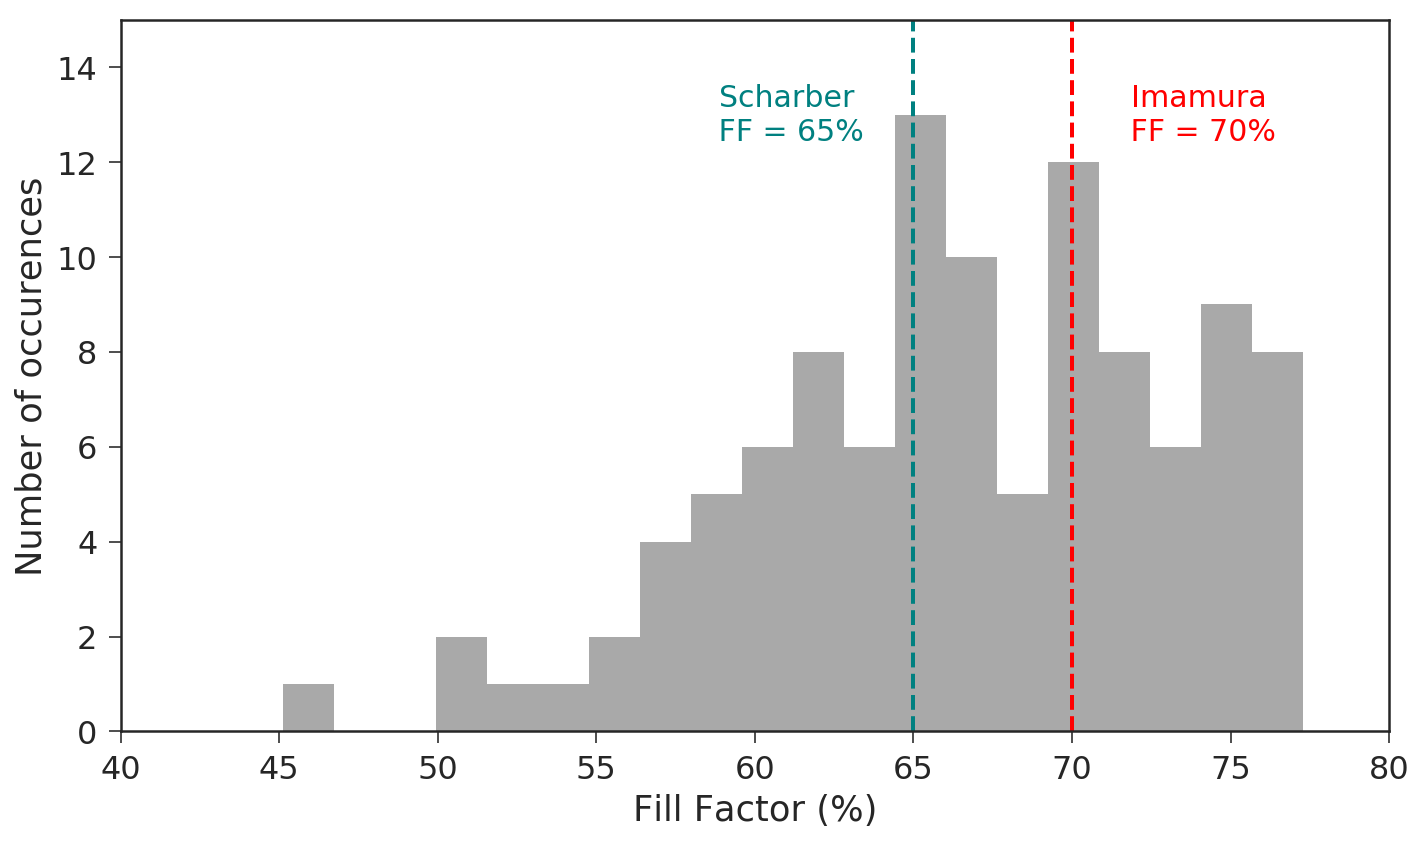

In [57]:
import scipy.stats as stats
import math

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

#plt.style.use('seaborn')
pal = sns.color_palette("hls", 8)
pal = pal.as_hex()

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes

x = df_sTD.ExperimentalFF
mean = np.mean(df_sTD.ExperimentalFF)
std = np.std(df_sTD.ExperimentalFF)

fig, ax1 = plt.subplots(figsize=(10, 6))
n, bins, patches = ax1.hist(x, bins = 20, density = False, color = 'darkgray')

ax1.axvline(65, ls = '--', color = 'teal', lw = 2)
ax1.axvline(70, ls = '--', color = 'r', lw = 2)
ax1.axis([40, 80, 0, 15])

ax1.text(61, 13, "Scharber\n FF = 65%", fontsize = 15, verticalalignment = 'center', ha = 'center', color = 'teal')
ax1.text(74, 13, "Imamura\n FF = 70%", fontsize = 15, verticalalignment = 'center', ha = 'center', color = 'r')

ax1.set(xlabel = 'Fill Factor (%)', ylabel = 'Number of occurences')
plt.tight_layout()
plt.savefig('../figures/FF_histogram.pdf')
plt.show()

# Comparing cross-validated models

In [58]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)
    


def CrossValModels(predicted, target):
    # predicted is the list of predicted values. Ex: df['ScharberPCEtotal'] or PerrisPCEcalc
    # target is the target experimental value. Ex: df['ExperimentalPCE']

    X = predicted
    y = target
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = 'r2')
    SEM_r2 = round((score.std() / math.sqrt(5)) , 3)
    #r2 = str(round(score.mean(), 3)) + ' +/- ' +  str(SEM_r2)
    r2 = round(float(score.mean()), 3)
    
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = 'neg_mean_absolute_error')
    score = np.multiply(score, -1)
    SEM_MAE = round((score.std() / math.sqrt(5)) , 2)
    #MAE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_MAE)
    MAE = round(score.mean(), 2) 
    
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = 'neg_mean_squared_error')
    score = np.sqrt(score * -1)
    SEM_RMSE = round((score.std() / math.sqrt(5)) , 2)
    #RMSE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_RMSE)
    RMSE = round(score.mean(), 2)
    
    MAPE_scorer = make_scorer(mean_absolute_percentage_error)
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = MAPE_scorer)
    score = score * 100
    SEM_MAPE = round((score.std() / math.sqrt(5)) , 2)
    MAPE = round(score.mean(), 2)

    return round(r2,2), SEM_r2, MAE, SEM_MAE, RMSE, SEM_RMSE, MAPE, SEM_MAPE

In [59]:
# Table 1 is using only DFT data
OPEP_B3LYP_PCE_Calc_values = []
OPEP_B3LYP_PCE_FF65_values = []
OPEP_B3LYP_PCE_FF67_values = []
OPEP_B3LYP_PCE_FF70_values = []

for i in range(len(LassoFF[-1])):
    # calculating PCE using models to predict Voc, Jsc, and FF
    OPEP_B3LYP_PCE_Calc_values.append(LassoVoc[-1][i] * (LassoFF[-1][i]/100) * LassoJsc[-1][i])
    # examining if setting the FF to various constants is better than predicting it for calculating PCE
    OPEP_B3LYP_PCE_FF65_values.append(LassoVoc[-1][i] * 0.65 * LassoJsc[-1][i])
    OPEP_B3LYP_PCE_FF67_values.append(LassoVoc[-1][i] * 0.67 * LassoJsc[-1][i])
    OPEP_B3LYP_PCE_FF70_values.append(LassoVoc[-1][i] * 0.70 * LassoJsc[-1][i])

OPEP_B3LYP_PCE_Calc = CrossValModels(OPEP_B3LYP_PCE_Calc_values, df['ExperimentalPCE'])
OPEP_B3LYP_PCE_FF65 = CrossValModels(OPEP_B3LYP_PCE_FF65_values, df['ExperimentalPCE'])
OPEP_B3LYP_PCE_FF67 = CrossValModels(OPEP_B3LYP_PCE_FF67_values, df['ExperimentalPCE'])
OPEP_B3LYP_PCE_FF70 = CrossValModels(OPEP_B3LYP_PCE_FF70_values, df['ExperimentalPCE'])

SchPCEtot = CrossValModels(df['ScharberPCEtotal'], df['ExperimentalPCE'])
SchPCEdon = CrossValModels(df['ScharberPCEdon'], df['ExperimentalPCE'])
SchPCEacc = CrossValModels(df['ScharberPCEacc'], df['ExperimentalPCE'])
SchPCElowestoptbg = CrossValModels(df['ScharberPCElowestoptbg'], df['ExperimentalPCE'])
ImamuraPCEtot = CrossValModels(df['ImamuraPCEtotal'], df['ExperimentalPCE'])
ImamuraPCEacc = CrossValModels(df['ImamuraPCEacc'], df['ExperimentalPCE'])
ImamuraPCEdon = CrossValModels(df['ImamuraPCEdon'], df['ExperimentalPCE'])
AlharbiPCEDon = CrossValModels(df['AlharbiPCEDon'], df['ExperimentalPCE'])
AlharbiPCEAcc = CrossValModels(df['AlharbiPCEAcc'], df['ExperimentalPCE'])
OPEP_B3LYP_PCE_pred= LassoPCE[0:8]


list_Table1 = [SchPCEtot, SchPCEdon, SchPCEacc,SchPCElowestoptbg, ImamuraPCEtot, ImamuraPCEacc, ImamuraPCEdon, AlharbiPCEDon,AlharbiPCEAcc, OPEP_B3LYP_PCE_Calc, OPEP_B3LYP_PCE_pred]
Table1 = pd.DataFrame(list_Table1, columns = ['r^2', '+/- r^2 SEM', 'MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['SchPCEtot', 'SchPCEdon', 'SchPCEacc', 'SchPCElowestoptbg', 'ImamuraPCEtot', 'ImamuraPCEacc', 'ImamuraPCEdon', 'AlharbiPCEDon', 'AlharbiPCEAcc', 'OPEP/B3LYP Calculated PCE', 'OPEP/B3LYP Predicted PCE'])
Table1.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table1)

#Table 2 is using only DFT data with experimental PCE > 9%
OPEP_B3LYP_PCE_Calc_highPCE_values = []
OPEP_B3LYP_PCE_FF65_highPCE_values = []
OPEP_B3LYP_PCE_FF67_highPCE_values = []
OPEP_B3LYP_PCE_FF70_highPCE_values = []
for i in range(len(LassoFF_highPCE[-1])):
    OPEP_B3LYP_PCE_Calc_highPCE_values.append(LassoVoc_highPCE[-1][i] * (LassoFF_highPCE[-1][i]/100) * LassoJsc_highPCE[-1][i])
    OPEP_B3LYP_PCE_FF65_highPCE_values.append(LassoVoc_highPCE[-1][i] * 0.65 * LassoJsc_highPCE[-1][i])
    OPEP_B3LYP_PCE_FF67_highPCE_values.append(LassoVoc_highPCE[-1][i] * 0.67 * LassoJsc_highPCE[-1][i])
    OPEP_B3LYP_PCE_FF70_highPCE_values.append(LassoVoc_highPCE[-1][i] * 0.70 * LassoJsc_highPCE[-1][i])
OPEP_B3LYP_PCE_Calc_highPCE = CrossValModels(OPEP_B3LYP_PCE_Calc_highPCE_values, df_highPCE['ExperimentalPCE'])
OPEP_B3LYP_PCE_FF65_highPCE = CrossValModels(OPEP_B3LYP_PCE_FF65_highPCE_values, df_highPCE['ExperimentalPCE'])
OPEP_B3LYP_PCE_FF67_highPCE = CrossValModels(OPEP_B3LYP_PCE_FF67_highPCE_values, df_highPCE['ExperimentalPCE'])
OPEP_B3LYP_PCE_FF70_highPCE = CrossValModels(OPEP_B3LYP_PCE_FF70_highPCE_values, df_highPCE['ExperimentalPCE'])

SchPCEtot_highPCE = CrossValModels(df_highPCE['ScharberPCEtotal'], df_highPCE['ExperimentalPCE'])
SchPCEdon_highPCE = CrossValModels(df_highPCE['ScharberPCEdon'], df_highPCE['ExperimentalPCE'])
SchPCEacc_highPCE = CrossValModels(df_highPCE['ScharberPCEacc'], df_highPCE['ExperimentalPCE'])
SchPCElowestoptbg_highPCE = CrossValModels(df_highPCE['ScharberPCElowestoptbg'], df_highPCE['ExperimentalPCE'])
ImamuraPCEtot_highPCE = CrossValModels(df_highPCE['ImamuraPCEtotal'], df_highPCE['ExperimentalPCE'])
ImamuraPCEacc_highPCE = CrossValModels(df_highPCE['ImamuraPCEacc'], df_highPCE['ExperimentalPCE'])
ImamuraPCEdon_highPCE = CrossValModels(df_highPCE['ImamuraPCEdon'], df_highPCE['ExperimentalPCE'])
AlharbiPCEDon_highPCE = CrossValModels(df_highPCE['AlharbiPCEDon'], df_highPCE['ExperimentalPCE'])
AlharbiPCEAcc_highPCE = CrossValModels(df_highPCE['AlharbiPCEAcc'], df_highPCE['ExperimentalPCE'])
OPEP_B3LYP_PCE_pred_highPCE = LassoPCE_highPCE[0:8]

list_Table2 = [OPEP_B3LYP_PCE_pred_highPCE, SchPCEtot_highPCE, SchPCEdon_highPCE, SchPCEacc_highPCE, SchPCElowestoptbg_highPCE, ImamuraPCEtot_highPCE, ImamuraPCEacc_highPCE, ImamuraPCEdon_highPCE, AlharbiPCEDon_highPCE, AlharbiPCEAcc_highPCE, OPEP_B3LYP_PCE_Calc_highPCE]
Table2 = pd.DataFrame(list_Table2, columns = ['r^2', '+/- r^2 SEM','MAE','+/- MAE SEM', 'RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['OPEP/B3LYP PCE pred highPCE', 'SchPCEtot_highPCE', 'SchPCEdon_highPCE', 'SchPCEacc_highPCE', 'SchPCElowestoptbg_highPCE', 'ImamuraPCEtot_highPCE', 'ImamuraPCEacc_highPCE', 'ImamuraPCEdon_highPCE', 'AlharbiPCEDon_highPCE', 'AlharbiPCEAcc_highPCE', 'OPEP/B3LYP PCE calc highPCE'])
Table2.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table2)

#Table 3 is using only sTD-DFT data with same experimental acceptor-donor pairs as Tables 1 and 2
OPEP_sTDDFT_PCE_calc_values = []
OPEP_sTDDFT_PCE_FF70_values = []

for i in range(len(LassoFF_sTD[-1])):
    OPEP_sTDDFT_PCE_calc_values.append(LassoVoc_sTD[-1][i] * (LassoFF_sTD[-1][i]/100) * LassoJsc_sTD[-1][i])
    OPEP_sTDDFT_PCE_FF70_values.append(LassoVoc_sTD[-1][i] * 0.70 * LassoJsc_sTD[-1][i])
OPEP_sTDDFT_PCE_calc = CrossValModels(OPEP_sTDDFT_PCE_calc_values, df['ExperimentalPCE'])
OPEP_sTDDFT_PCE_FF70 = CrossValModels(OPEP_sTDDFT_PCE_FF70_values, df['ExperimentalPCE'])

sTDDFTSchPCETot = CrossValModels(df['sTDDFTScharberPCETot'], df['ExperimentalPCE'])
sTDDFTSchPCEAcc = CrossValModels(df['sTDDFTScharberPCEAcc'], df['ExperimentalPCE'])
sTDDFTSchPCEDon = CrossValModels(df['sTDDFTScharberPCEDon'], df['ExperimentalPCE'])
OPEP_sTDDFT_PCE_pred = LassoPCE_sTD[0:8]

list_Table3 = [sTDDFTSchPCETot, sTDDFTSchPCEAcc, sTDDFTSchPCEDon, OPEP_sTDDFT_PCE_pred, OPEP_sTDDFT_PCE_calc, OPEP_sTDDFT_PCE_FF70]
Table3 = pd.DataFrame(list_Table3, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['sTDDFTSchPCETot', 'sTDDFTSchPCEAcc', 'sTDDFTSchPCEDon', 'OPEP/sTDDFT PCE pred', 'OPEP/sTDDFT PCE calc', 'OPEP/sTDDFT PCE FF=70'])
Table3.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table3)

#Table 4 is using only sTD-DFT data with same experimental acceptor-donor pairs as Tables 1 and 2, but with experimental PCE > 9%
OPEP_sTDDFT_PCE_calc_highPCE_values = []
OPEP_sTDDFT_PCE_FF70_highPCE_values = []
for i in range(len(LassoFF_sTD_highPCE[-1])):
    OPEP_sTDDFT_PCE_calc_highPCE_values.append(LassoVoc_sTD_highPCE[-1][i] * (LassoFF_sTD_highPCE[-1][i]/100) * LassoJsc_sTD_highPCE[-1][i])
    OPEP_sTDDFT_PCE_FF70_highPCE_values.append(LassoVoc_sTD_highPCE[-1][i] * 0.70 * LassoJsc_sTD_highPCE[-1][i])
OPEP_sTDDFT_PCE_calc_highPCE = CrossValModels(OPEP_sTDDFT_PCE_calc_highPCE_values, df_highPCE['ExperimentalPCE'])
OPEP_sTDDFT_PCE_FF70_highPCE = CrossValModels(OPEP_sTDDFT_PCE_FF70_highPCE_values, df_highPCE['ExperimentalPCE'])

sTDDFTSchPCETot_highPCE = CrossValModels(df_highPCE['sTDDFTScharberPCETot'], df_highPCE['ExperimentalPCE'])
sTDDFTSchPCEAcc_highPCE = CrossValModels(df_highPCE['sTDDFTScharberPCEAcc'], df_highPCE['ExperimentalPCE'])
sTDDFTSchPCEDon_highPCE = CrossValModels(df_highPCE['sTDDFTScharberPCEDon'], df_highPCE['ExperimentalPCE'])
OPEP_sTDDFT_PCE_pred_highPCE = LassoPCE_sTD_highPCE[0:8]

list_Table4 = [sTDDFTSchPCETot_highPCE, sTDDFTSchPCEAcc_highPCE, sTDDFTSchPCEDon_highPCE, OPEP_sTDDFT_PCE_pred_highPCE, OPEP_sTDDFT_PCE_calc_highPCE, OPEP_sTDDFT_PCE_FF70_highPCE]
Table4 = pd.DataFrame(list_Table4, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['sTDDFTSchPCETot_highPCE', 'sTDDFTSchPCEAcc_highPCE', 'sTDDFTSchPCEDon_highPCE', 'OPEP/sTDDFT PCE pred highPCE', 'OPEP/sTDDFT PCE calc highPCE', 'OPEP/sTDDFT PCE FF=70 highPCE'])
Table4.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table4)

#Table 5 is using only sTD-DFT data but with additional acceptor-donor pairs
OPEP_sTDDFT_PCE_calc_expanded_values = []
OPEP_sTDDFT_PCE_FF70_expanded_values = []
for i in range(len(LassoFF_sTD_all[-1])):
    OPEP_sTDDFT_PCE_calc_expanded_values.append(LassoVoc_sTD_all[-1][i] * (LassoFF_sTD_all[-1][i]/100) * LassoJsc_sTD_all[-1][i])
    OPEP_sTDDFT_PCE_FF70_expanded_values.append(LassoVoc_sTD_all[-1][i] * 0.70 * LassoJsc_sTD_all[-1][i])
OPEP_sTDDFT_PCE_calc_expanded = CrossValModels(OPEP_sTDDFT_PCE_calc_expanded_values, df_sTD['ExperimentalPCE'])
OPEP_sTDDFT_PCE_FF70_expanded = CrossValModels(OPEP_sTDDFT_PCE_FF70_expanded_values, df_sTD['ExperimentalPCE'])

sTDDFTSchPCETotall = CrossValModels(df_sTD['sTDDFTScharberPCETot'], df_sTD['ExperimentalPCE'])
sTDDFTSchPCEAccall = CrossValModels(df_sTD['sTDDFTScharberPCEAcc'], df_sTD['ExperimentalPCE'])
sTDDFTSchPCEDonall = CrossValModels(df_sTD['sTDDFTScharberPCEDon'], df_sTD['ExperimentalPCE'])
OPEP_sTDDFT_PCE_pred_expanded = LassoPCE_sTD_all[0:8]

list_Table5 = [sTDDFTSchPCETotall, sTDDFTSchPCEAccall, sTDDFTSchPCEDonall, OPEP_sTDDFT_PCE_pred_expanded, OPEP_sTDDFT_PCE_calc_expanded, OPEP_sTDDFT_PCE_FF70_expanded]
Table5 = pd.DataFrame(list_Table5, columns = ['r^2', '+/- r^2 SEM','MAE','+/- MAE SEM', 'RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['sTDDFTSchPCETotall', 'sTDDFTSchPCEAccall', 'sTDDFTSchPCEDonall', 'OPEP/sTDDFT Expanded PCE pred', 'OPEP/sTDDFT Expanded PCE calc', 'OPEP/sTDDFT Expanded PCE FF=70'])
Table5.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table5)

#Table 6 is using only sTD-DFT data but with additional acceptor-donor pairs, and PCE > 9%
OPEP_sTDDFT_PCE_calc_expanded_highPCE_values = []
OPEP_sTDDFT_PCE_FF70_expanded_highPCE_values = []
for i in range(len(LassoFF_sTD_highPCE_all[-1])):
    OPEP_sTDDFT_PCE_calc_expanded_highPCE_values.append(LassoVoc_sTD_highPCE_all[-1][i] * (LassoFF_sTD_highPCE_all[-1][i]/100) * LassoJsc_sTD_highPCE_all[-1][i])
    OPEP_sTDDFT_PCE_FF70_expanded_highPCE_values.append(LassoVoc_sTD_highPCE_all[-1][i] * 0.70 * LassoJsc_sTD_highPCE_all[-1][i])
OPEP_sTDDFT_PCE_calc_expanded_highPCE = CrossValModels(OPEP_sTDDFT_PCE_calc_expanded_highPCE_values, df_sTD_highPCE['ExperimentalPCE'])
OPEP_sTDDFT_PCE_FF70_expanded_highPCE = CrossValModels(OPEP_sTDDFT_PCE_FF70_expanded_highPCE_values, df_sTD_highPCE['ExperimentalPCE'])

sTDDFTSchPCETotall_highPCE = CrossValModels(df_sTD_highPCE['sTDDFTScharberPCETot'], df_sTD_highPCE['ExperimentalPCE'])
sTDDFTSchPCEAccall_highPCE = CrossValModels(df_sTD_highPCE['sTDDFTScharberPCEAcc'], df_sTD_highPCE['ExperimentalPCE'])
sTDDFTSchPCEDonall_highPCE = CrossValModels(df_sTD_highPCE['sTDDFTScharberPCEDon'], df_sTD_highPCE['ExperimentalPCE'])
OPEP_sTDDFT_PCE_pred_expanded_highPCE = LassoPCE_sTD_highPCE_all[0:8]

list_Table6 = [sTDDFTSchPCETotall_highPCE, sTDDFTSchPCEAccall_highPCE, sTDDFTSchPCEDonall_highPCE, OPEP_sTDDFT_PCE_pred_expanded_highPCE, OPEP_sTDDFT_PCE_calc_expanded_highPCE, OPEP_sTDDFT_PCE_FF70_expanded_highPCE]
Table6 = pd.DataFrame(list_Table6, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['sTDDFTSchPCETotall_highPCE', 'sTDDFTSchPCEAccall_highPCE', 'sTDDFTSchPCEDonall_highPCE', 'OPEP/sTDDFT PCE Expanded pred highPCE', 'OPEP/sTDDFT PCE Expanded calc highPCE', 'OPEP/sTDDFT PCE Expanded FF=70 highPCE'])
Table6.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table6)




,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoPCE,0.509,0.003,1.967,0.019,2.6637,0.00691,26.8453,0.13136
Hutchison_Lasso_PCEcalc,0.350,0.110,2.280,0.180,2.9000,0.22000,29.8900,4.27000
AlharbiPCEDon,0.080,0.044,3.140,0.250,3.5800,0.27000,41.5600,5.09000
AlharbiPCEAcc,0.040,0.063,3.100,0.280,3.6400,0.29000,45.2200,7.68000
SchPCEdon,0.010,0.038,3.220,0.260,3.7100,0.27000,44.3200,5.59000
ImamuraPCEdon,0.010,0.038,3.220,0.260,3.7100,0.27000,44.3200,5.59000
SchPCEtot,0.010,0.062,3.190,0.320,3.7200,0.32000,45.2000,6.94000
ImamuraPCEtot,0.010,0.062,3.190,0.320,3.7200,0.32000,45.2000,6.94000
SchPCEacc,-0.090,0.051,3.280,0.320,3.9000,0.30000,48.4400,7.54000
ImamuraPCEacc,-0.090,0.051,3.280,0.320,3.9000,0.30000,48.4400,7.54000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoPCE_highPCE,0.642,0.006,1.238,0.01,1.5261,0.01228,10.1248,0.05697
Hutchison_Lasso_PCEcalc_highPCE,0.490,0.096,1.360,0.15,1.6400,0.16000,11.3200,1.34000
AlharbiPCEDon_highPCE,-0.120,0.171,2.080,0.21,2.4600,0.21000,17.5100,1.55000
AlharbiPCEAcc_highPCE,-0.150,0.157,2.250,0.27,2.5100,0.22000,18.7100,2.20000
SchPCEdon_highPCE,-0.230,0.212,2.210,0.21,2.5300,0.17000,18.5600,1.67000
ImamuraPCEdon_highPCE,-0.230,0.212,2.210,0.21,2.5300,0.17000,18.5600,1.67000
SchPCEacc_highPCE,-0.210,0.125,2.330,0.25,2.5900,0.22000,19.4900,2.05000
ImamuraPCEacc_highPCE,-0.210,0.125,2.330,0.25,2.5900,0.22000,19.4900,2.05000
SchPCElowestoptbg_highPCE,-0.300,0.112,2.420,0.22,2.6800,0.19000,20.2500,1.78000
SchPCEtot_highPCE,-0.470,0.210,2.510,0.19,2.8000,0.16000,21.1500,1.62000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoPCE_sTD,0.484,0.009,2.114,0.027,2.7299,0.02358,31.0152,0.20815
Hutchison_Lasso_PCEcalc_sTD,0.420,0.061,2.290,0.180,2.7900,0.20000,32.7000,3.43000
Hutchison_Lasso_PCE_FF70_sTD,0.430,0.056,2.260,0.220,2.8000,0.24000,32.6100,4.40000
sTDDFTSchPCEDon,0.100,0.060,3.070,0.270,3.5300,0.29000,40.5900,4.92000
sTDDFTSchPCETot,0.060,0.087,3.050,0.330,3.6200,0.36000,42.6100,7.07000
sTDDFTSchPCEAcc,-0.050,0.048,3.200,0.300,3.8200,0.29000,46.9500,7.27000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoPCE_sTD_highPCE,0.63,0.005,1.226,0.016,1.553,0.01075,10.375,0.08277
Hutchison_Lasso_PCEcalc_sTD_highPCE,0.42,0.092,1.450,0.060,1.730,0.08000,12.330,0.55000
Hutchison_Lasso_PCE_FF70_sTD_highPCE,0.27,0.114,1.630,0.070,1.960,0.08000,13.910,0.87000
sTDDFTSchPCEAcc_highPCE,-0.24,0.133,2.340,0.230,2.610,0.19000,19.550,1.73000
sTDDFTSchPCEDon_highPCE,-0.26,0.146,2.310,0.220,2.620,0.18000,19.450,1.63000
sTDDFTSchPCETot_highPCE,-0.26,0.134,2.370,0.220,2.630,0.17000,19.840,1.58000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutchison_Lasso_PCEcalc_sTD_all,0.410,0.083,2.050,0.180,2.5400,0.21000,28.0900,5.29000
Hutchison_Lasso_PCE_FF70_sTD_all,0.410,0.082,2.030,0.210,2.5600,0.22000,27.8100,5.34000
Hutch_LassoPCE_sTD_all,0.458,0.003,2.027,0.011,2.6311,0.00636,28.0653,0.36579
sTDDFTSchPCEDonall,-0.120,0.046,3.010,0.180,3.5700,0.16000,40.4300,6.30000
sTDDFTSchPCETotall,-0.180,0.072,3.030,0.140,3.6400,0.11000,41.4900,6.53000
sTDDFTSchPCEAccall,-0.240,0.082,3.040,0.170,3.7200,0.13000,43.2000,7.03000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoPCE_sTD_highPCE_all,0.552,0.021,1.297,0.025,1.6008,0.03626,10.9187,0.26778
Hutchison_Lasso_PCEcalc_sTD_highPCE_all,0.190,0.263,1.370,0.130,1.6200,0.10000,11.5900,1.17000
Hutchison_Lasso_PCE_FF70_sTD_highPCE_all,0.020,0.313,1.500,0.140,1.7900,0.12000,12.7800,1.35000
sTDDFTSchPCEDonall_highPCE,-0.690,0.432,2.210,0.250,2.4500,0.23000,18.4100,1.79000
sTDDFTSchPCEAccall_highPCE,-0.710,0.430,2.220,0.240,2.4700,0.22000,18.5100,1.92000
sTDDFTSchPCETotall_highPCE,-0.740,0.447,2.240,0.250,2.4800,0.22000,18.7000,1.93000


# Comparing models for FF, Jsc, and Voc

In [60]:
#Table 7 is comparing all models for Fill Factor (FF) with high PCE
ScharberFF_highPCE = CrossValModels(df_highPCE['ScharberFF'], df_highPCE['ExperimentalFF'])
AlharbiFFDon_highPCE = CrossValModels(df_highPCE['AlharbiFFDon'], df_highPCE['ExperimentalFF'])
AlharbiFFAcc_highPCE = CrossValModels(df_highPCE['AlharbiFFAcc'], df_highPCE['ExperimentalFF'])
ImamuraFF_highPCE = CrossValModels(df_highPCE['ImamuraFF'], df_highPCE['ExperimentalFF'])
OPEP_B3LYP_FF_highPCE = LassoFF_highPCE[0:8]
OPEP_sTDDFT_FF_highPCE = LassoFF_sTD_highPCE[0:8]
OPEP_sTDDFT_Expanded_FF_highPCE = LassoFF_sTD_highPCE_all[0:8]

list_Table7 = [ScharberFF_highPCE, AlharbiFFDon_highPCE, AlharbiFFAcc_highPCE, ImamuraFF_highPCE, OPEP_B3LYP_FF_highPCE, OPEP_sTDDFT_FF_highPCE, OPEP_sTDDFT_Expanded_FF_highPCE]
Table7 = pd.DataFrame(list_Table7, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['ScharberFF_highPCE', 'AlharbiFFDon_highPCE', 'AlharbiFFAcc_highPCE', 'ImamuraFF_highPCE', 'OPEP/B3LYP FF highPCE', 'OPEP/sTDDFT FF highPCE', 'OPEP/sTDDFT Expanded FF highPCE'])
Table7.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table7)


#Table 7b is comparing all models for Fill Factor (FF) 
ScharberFF = CrossValModels(df['ScharberFF'], df['ExperimentalFF'])
AlharbiFFDon = CrossValModels(df['AlharbiFFDon'], df['ExperimentalFF'])
AlharbiFFAcc = CrossValModels(df['AlharbiFFAcc'], df['ExperimentalFF'])
ImamuraFF = CrossValModels(df['ImamuraFF'], df['ExperimentalFF'])
OPEP_B3LYP_FF = LassoFF[0:8]
OPEP_sTDDFT_FF = LassoFF_sTD[0:8]
OPEP_sTDDFT_Expanded_FF = LassoFF_sTD_all[0:8]

list_Table7b = [ScharberFF, AlharbiFFDon, AlharbiFFAcc, ImamuraFF, OPEP_B3LYP_FF, OPEP_sTDDFT_FF, OPEP_sTDDFT_Expanded_FF]
Table7b = pd.DataFrame(list_Table7b, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['ScharberFF', 'AlharbiFFDon', 'AlharbiFFAcc', 'ImamuraFF', 'OPEP/B3LYP FF', 'OPEP/sTDDFT FF', 'OPEP/sTDDFT Expanded FF'])
Table7b.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table7b)


#Table 8 is comparing all models for short circuit current (Jsc) for high PCE
ScharberJscAcc_highPCE = CrossValModels(df_highPCE['ScharberJscAcc'], df_highPCE['ExperimentalJsc'])
ImamuraTotalJsc_highPCE = CrossValModels(df_highPCE['ImamuraTotalJsc'], df_highPCE['ExperimentalJsc'])
ImamuraJscAcc_highPCE = CrossValModels(df_highPCE['ImamuraJscAcc'], df_highPCE['ExperimentalJsc'])
ImamuraJscDon_highPCE = CrossValModels(df_highPCE['ImamuraJscDon'], df_highPCE['ExperimentalJsc'])
ScharberTotalJsc_highPCE = CrossValModels(df_highPCE['ScharberTotalJsc'], df_highPCE['ExperimentalJsc'])
ScharberJscDon_highPCE = CrossValModels(df_highPCE['ScharberJscDon'], df_highPCE['ExperimentalJsc'])
ScharberJsclowestoptbg_highPCE = CrossValModels(df_highPCE['ScharberJsclowestoptbg'], df_highPCE['ExperimentalJsc'])
OPEP_B3LYP_Jsc_highPCE = LassoJsc_highPCE[0:8]
OPEP_sTDDFT_Jsc_highPCE = LassoJsc_sTD_highPCE[0:8]
OPEP_sTDDFT_Expanded_Jsc_highPCE = LassoJsc_sTD_highPCE_all[0:8]

list_Table8 = [ScharberJscAcc_highPCE, ImamuraTotalJsc_highPCE, ImamuraJscAcc_highPCE, ImamuraJscDon_highPCE, ScharberTotalJsc_highPCE, ScharberJscDon_highPCE, ScharberJsclowestoptbg_highPCE, OPEP_B3LYP_Jsc_highPCE, OPEP_sTDDFT_Jsc_highPCE, OPEP_sTDDFT_Expanded_Jsc_highPCE]
Table8 = pd.DataFrame(list_Table8, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['ScharberJscAcc_highPCE', 'ImamuraTotalJsc_highPCE', 'ImamuraJscAcc_highPCE', 'ImamuraJscDon_highPCE', 'ScharberTotalJsc_highPCE', 'ScharberJscDon_highPCE', 'ScharberJsclowestoptbg_highPCE', 'OPEP/B3LYP Jsc highPCE', 'OPEP/sTDDFT Jsc highPCE', 'OPEP/sTDDFT Expanded Jsc highPCE '])
Table8.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table8)

#Table 8b is comparing all models for short circuit current (Jsc)
ScharberJscAcc = CrossValModels(df['ScharberJscAcc'], df['ExperimentalJsc'])
ImamuraTotalJsc = CrossValModels(df['ImamuraTotalJsc'], df['ExperimentalJsc'])
ImamuraJscAcc = CrossValModels(df['ImamuraJscAcc'], df['ExperimentalJsc'])
ImamuraJscDon = CrossValModels(df['ImamuraJscDon'], df['ExperimentalJsc'])
ScharberTotalJsc = CrossValModels(df['ScharberTotalJsc'], df['ExperimentalJsc'])
ScharberJscDon = CrossValModels(df['ScharberJscDon'], df['ExperimentalJsc'])
ScharberJsclowestoptbg = CrossValModels(df['ScharberJsclowestoptbg'], df['ExperimentalJsc'])
OPEP_B3LYP_Jsc = LassoJsc[0:8]
OPEP_sTDDFT_Jsc = LassoJsc_sTD[0:8]
OPEP_sTDDFT_Expanded_Jsc = LassoJsc_sTD_all[0:8]


list_Table8b = [ScharberJscAcc, ImamuraTotalJsc, ImamuraJscAcc, ImamuraJscDon, ScharberTotalJsc, ScharberJscDon, ScharberJsclowestoptbg, OPEP_B3LYP_Jsc, OPEP_sTDDFT_Jsc, OPEP_sTDDFT_Expanded_Jsc]
Table8b = pd.DataFrame(list_Table8b, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['ScharberJscAcc', 'ImamuraTotalJsc', 'ImamuraJscAcc', 'ImamuraJscDon', 'ScharberTotalJsc', 'ScharberJscDon', 'ScharberJsclowestoptbg','OPEP/B3LYP Jsc', 'OPEP/sTDDFT Jsc', 'OPEP/sTDDFT Expanded Jsc'])
Table8b.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table8b)

#Table 9 is comparing all models for open circuit voltage (Voc) for high PCE
AlharbiVocAcc_highPCE = CrossValModels(df_highPCE['AlharbiVocAcc'], df_highPCE['ExperimentalVoc'])
AlharbiVocDon_highPCE = CrossValModels(df_highPCE['AlharbiVocDon'], df_highPCE['ExperimentalVoc'])
ImamuraVoc_highPCE = CrossValModels(df_highPCE['ImamuraVoc'], df_highPCE['ExperimentalVoc'])
ScharberVoc_highPCE = CrossValModels(df_highPCE['ScharberVoc'], df_highPCE['ExperimentalVoc'])
OPEP_B3LYP_Voc_highPCE = LassoVoc_highPCE[0:8]
OPEP_sTDDFT_Voc_highPCE = LassoVoc_sTD_highPCE[0:8]
OPEP_sTDDFT_Expanded_Voc_highPCE = LassoVoc_sTD_highPCE_all[0:8]

list_Table9 = [AlharbiVocAcc_highPCE, AlharbiVocDon_highPCE, ImamuraVoc_highPCE,  ScharberVoc_highPCE, OPEP_B3LYP_Voc_highPCE, OPEP_sTDDFT_Voc_highPCE, OPEP_sTDDFT_Expanded_Voc_highPCE]
Table9 = pd.DataFrame(list_Table9, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['AlharbiVocAcc_highPCE', 'AlharbiVocDon_highPCE', 'ImamuraVoc_highPCE', 'ScharberVoc_highPCE', 'OPEP/B3LYP Voc highPCE', 'OPEP/sTDDFT Voc highPCE', 'OPEP/sTDDFT Expanded Voc highPCE'])
Table9.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table9)

#Table 9b is comparing all models for open circuit voltage (Voc)
AlharbiVocAcc = CrossValModels(df['AlharbiVocAcc'], df['ExperimentalVoc'])
AlharbiVocDon = CrossValModels(df['AlharbiVocDon'], df['ExperimentalVoc'])
ImamuraVoc = CrossValModels(df['ImamuraVoc'], df['ExperimentalVoc'])
ScharberVoc = CrossValModels(df['ScharberVoc'], df['ExperimentalVoc'])
OPEP_B3LYP_Voc = LassoVoc[0:8]
OPEP_sTDDFT_Voc = LassoVoc_sTD[0:8]
OPEP_sTDDFT_Expanded_Voc = LassoVoc_sTD_all[0:8]

list_Table9b = [AlharbiVocAcc, AlharbiVocDon, ImamuraVoc,  ScharberVoc, OPEP_B3LYP_Voc, OPEP_sTDDFT_Voc, OPEP_sTDDFT_Expanded_Voc]
Table9b = pd.DataFrame(list_Table9b, columns = ['r^2', '+/- r^2 SEM','MAE', '+/- MAE SEM','RMSE', '+/- RMSE SEM', 'MAPE', '+/- MAPE SEM'], index = ['AlharbiVocAcc', 'AlharbiVocDon', 'ImamuraVoc', 'ScharberVoc', 'OPEP/B3LYP Voc', 'OPEP/sTDDFT Voc', 'OPEP/sTDDFT Expanded Voc'])
Table9b.sort_values(by=["RMSE"], inplace=True, ascending = True)
display(Table9b)

,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoFF_highPCE,0.399,0.016,3.186,0.041,4.1848,0.05317,4.7716,0.06334
Hutch_LassoFF_sTD_highPCE_all,0.310,0.003,3.531,0.020,4.4459,0.00993,5.2893,0.02315
Hutch_LassoFF_sTD_highPCE,0.307,0.008,3.528,0.053,4.4919,0.02731,5.2885,0.06794
AlharbiFFDon_highPCE,0.050,0.056,4.070,0.260,5.0000,0.30000,6.0700,0.42000
ScharberFF_highPCE,-0.120,0.063,4.510,0.260,5.4300,0.31000,6.7000,0.44000
ImamuraFF_highPCE,-0.120,0.063,4.510,0.260,5.4300,0.31000,6.7000,0.44000
AlharbiFFAcc_highPCE,-0.130,0.062,4.510,0.270,5.4500,0.30000,6.7000,0.44000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoFF,0.310,0.005,4.371,0.011,5.6883,0.02125,6.8701,0.01497
Hutch_LassoFF_sTD_all,0.231,0.003,4.583,0.016,5.8065,0.01022,7.2243,0.01660
Hutch_LassoFF_sTD,0.232,0.006,4.781,0.031,6.0016,0.02486,7.4849,0.04743
ScharberFF,-0.040,0.017,5.550,0.600,6.7500,0.64000,8.7000,1.05000
ImamuraFF,-0.040,0.017,5.550,0.600,6.7500,0.64000,8.7000,1.05000
AlharbiFFDon,-0.060,0.027,5.590,0.600,6.7900,0.64000,8.7600,1.04000
AlharbiFFAcc,-0.070,0.012,5.660,0.620,6.8400,0.66000,8.8700,1.08000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoJsc_sTD_highPCE,0.739,0.004,1.444,0.014,1.7783,0.01454,6.9891,0.04363
Hutch_LassoJsc_sTD_highPCE_all,0.682,0.011,1.557,0.021,1.9240,0.03217,7.6997,0.13710
Hutch_LassoJsc_highPCE,0.662,0.003,1.700,0.009,2.0237,0.00793,8.1477,0.07646
ScharberJscAcc_highPCE,-0.340,0.466,2.670,0.260,3.1100,0.25000,13.0500,1.17000
ImamuraJscAcc_highPCE,-0.340,0.466,2.670,0.260,3.1100,0.25000,13.0500,1.17000
ScharberJsclowestoptbg_highPCE,-0.410,0.491,2.790,0.270,3.2100,0.27000,13.7200,1.28000
ImamuraTotalJsc_highPCE,-0.660,0.474,3.000,0.310,3.5700,0.21000,15.0900,1.51000
ScharberTotalJsc_highPCE,-0.660,0.474,3.000,0.310,3.5700,0.21000,15.0900,1.51000
ImamuraJscDon_highPCE,-0.920,0.618,3.150,0.200,3.7300,0.20000,15.9500,1.22000
ScharberJscDon_highPCE,-0.920,0.618,3.150,0.200,3.7300,0.20000,15.9500,1.22000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoJsc_sTD_all,0.566,0.007,2.487,0.017,3.4664,0.02760,18.7152,0.11160
Hutch_LassoJsc,0.579,0.002,2.658,0.019,3.6408,0.00709,19.6506,0.06671
Hutch_LassoJsc_sTD,0.551,0.005,2.733,0.015,3.7602,0.02175,21.2513,0.12768
ImamuraTotalJsc,0.180,0.074,4.230,0.400,5.0200,0.44000,30.8100,4.46000
ScharberTotalJsc,0.180,0.074,4.230,0.400,5.0200,0.44000,30.8100,4.46000
ScharberJscAcc,0.100,0.082,4.250,0.420,5.2400,0.47000,32.2400,4.90000
ImamuraJscAcc,0.100,0.082,4.250,0.420,5.2400,0.47000,32.2400,4.90000
ScharberJsclowestoptbg,0.090,0.088,4.270,0.470,5.2800,0.49000,32.2100,5.20000
ImamuraJscDon,0.080,0.052,4.500,0.270,5.3000,0.33000,31.9000,2.75000
ScharberJscDon,0.080,0.052,4.500,0.270,5.3000,0.33000,31.9000,2.75000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoVoc_sTD_highPCE,0.610,0.027,0.044,0.001,0.0584,0.00201,5.3251,0.12638
Hutch_LassoVoc_sTD_highPCE_all,0.519,0.014,0.047,0.001,0.0614,0.00091,5.5670,0.06795
Hutch_LassoVoc_highPCE,0.552,0.025,0.050,0.001,0.0627,0.00170,6.0547,0.12916
ImamuraVoc_highPCE,-0.010,0.224,0.060,0.010,0.0800,0.01000,7.4400,0.67000
ScharberVoc_highPCE,-0.010,0.224,0.060,0.010,0.0800,0.01000,7.4400,0.67000
AlharbiVocAcc_highPCE,-0.450,0.428,0.070,0.010,0.0900,0.01000,8.3800,1.17000
AlharbiVocDon_highPCE,-0.230,0.089,0.070,0.010,0.0900,0.01000,8.8300,1.08000


,r^2,+/- r^2 SEM,MAE,+/- MAE SEM,RMSE,+/- RMSE SEM,MAPE,+/- MAPE SEM
Hutch_LassoVoc_sTD,0.671,0.010,0.051,0.001,0.0646,0.00096,6.2813,0.09245
Hutch_LassoVoc_sTD_all,0.485,0.015,0.058,0.001,0.0755,0.00112,7.0832,0.07326
Hutch_LassoVoc,0.479,0.010,0.063,0.000,0.0813,0.00076,7.9126,0.05424
ImamuraVoc,0.300,0.090,0.070,0.010,0.0900,0.01000,8.6400,1.07000
ScharberVoc,0.300,0.090,0.070,0.010,0.0900,0.01000,8.6400,1.07000
AlharbiVocDon,-0.120,0.097,0.090,0.010,0.1100,0.01000,11.1500,0.96000
AlharbiVocAcc,-1.040,0.870,0.100,0.010,0.1400,0.03000,12.7900,2.27000


# Analysis Figures

In [61]:
def make_barplots(param, ax, stat=None):
    '''
    Makes a barplot comparing OPEP, Scharber, Imamura, and Alharbi models

    Parameters
    ----------
    param: str
        options are 'FF', 'Jsc', 'Voc', or 'PCE'
    ax: str
        axes in figure to draw barplot on
    stat: None or str
        if None, MAE and RMSE will be plotted. If 'MAPE', mean absolute percent error (MAPE) will be plotted.
    '''    
    if param == 'FF':
        MAE = [ScharberFF_highPCE[2], ImamuraFF_highPCE[2], AlharbiFFDon_highPCE[2], OPEP_B3LYP_FF_highPCE[2], OPEP_B3LYP_FF_highPCE[2] ]
        SEM_MAE =[ScharberFF_highPCE[3], ImamuraFF_highPCE[3], AlharbiFFDon_highPCE[3], OPEP_B3LYP_FF_highPCE[3], OPEP_B3LYP_FF_highPCE[3] ]
        RMSE = [ScharberFF_highPCE[4], ImamuraFF_highPCE[4], AlharbiFFDon_highPCE[4], OPEP_B3LYP_FF_highPCE[4], OPEP_B3LYP_FF_highPCE[4] ]
        SEM_RMSE=[ScharberFF_highPCE[5], ImamuraFF_highPCE[5], AlharbiFFDon_highPCE[5], OPEP_B3LYP_FF_highPCE[5], OPEP_B3LYP_FF_highPCE[5] ]
        MAPE = [ScharberFF_highPCE[6], ImamuraFF_highPCE[6], AlharbiFFDon_highPCE[6], OPEP_B3LYP_FF_highPCE[6], OPEP_B3LYP_FF_highPCE[6]]
        SEM_MAPE =  [ScharberFF_highPCE[7], ImamuraFF_highPCE[7], AlharbiFFDon_highPCE[7], OPEP_B3LYP_FF_highPCE[7], OPEP_B3LYP_FF_highPCE[7]]
        labels = ['Scharber', 'Imamura', 'Alharbi', 'OPEP / B3LYP', 'OPEP / sTD-DFT']
        x = np.arange(5)
        
    elif param == 'Voc':
        MAE = [ScharberVoc_highPCE[2], ImamuraVoc_highPCE[2], AlharbiVocDon_highPCE[2], OPEP_B3LYP_Voc_highPCE[2], OPEP_sTDDFT_Voc_highPCE[2] ]
        SEM_MAE = [ScharberVoc_highPCE[3], ImamuraVoc_highPCE[3], AlharbiVocDon_highPCE[3], OPEP_B3LYP_Voc_highPCE[3], OPEP_sTDDFT_Voc_highPCE[3]]
        RMSE = [ScharberVoc_highPCE[4], ImamuraVoc_highPCE[4], AlharbiVocDon_highPCE[4], OPEP_B3LYP_Voc_highPCE[4], OPEP_sTDDFT_Voc_highPCE[4]]
        SEM_RMSE=[ScharberVoc_highPCE[5], ImamuraVoc_highPCE[5], AlharbiVocDon_highPCE[5], OPEP_B3LYP_Voc_highPCE[5], OPEP_sTDDFT_Voc_highPCE[5]]
        MAPE = [ScharberVoc_highPCE[6], ImamuraVoc_highPCE[6], AlharbiVocDon_highPCE[6], OPEP_B3LYP_Voc_highPCE[6], OPEP_sTDDFT_Voc_highPCE[6]]
        SEM_MAPE =  [ScharberVoc_highPCE[7], ImamuraVoc_highPCE[7], AlharbiVocDon_highPCE[7], OPEP_B3LYP_Voc_highPCE[7], OPEP_sTDDFT_Voc_highPCE[7]]
        labels = ['Scharber', 'Imamura', 'Alharbi', 'OPEP / B3LYP', 'OPEP / sTD-DFT']
        x = np.arange(5)
    
    elif param == 'Jsc':
        MAE = [ScharberJscDon_highPCE[2], ImamuraJscDon_highPCE[2], OPEP_B3LYP_Jsc_highPCE[2], OPEP_sTDDFT_Jsc_highPCE[2] ]
        SEM_MAE = [ScharberJscDon_highPCE[3], ImamuraJscDon_highPCE[3],  OPEP_B3LYP_Jsc_highPCE[3], OPEP_sTDDFT_Jsc_highPCE[3]]
        RMSE = [ScharberJscDon_highPCE[4], ImamuraJscDon_highPCE[4],  OPEP_B3LYP_Jsc_highPCE[4], OPEP_sTDDFT_Jsc_highPCE[4]]
        SEM_RMSE=[ScharberJscDon_highPCE[5], ImamuraJscDon_highPCE[5],  OPEP_B3LYP_Jsc_highPCE[5], OPEP_sTDDFT_Jsc_highPCE[5]]
        MAPE = [ScharberJscDon_highPCE[6], ImamuraJscDon_highPCE[6], OPEP_B3LYP_Jsc_highPCE[6], OPEP_sTDDFT_Jsc_highPCE[6]]
        SEM_MAPE =  [ScharberJscDon_highPCE[7], ImamuraJscDon_highPCE[7], OPEP_B3LYP_Jsc_highPCE[7], OPEP_sTDDFT_Jsc_highPCE[7]]
        labels = ['Scharber', 'Imamura', 'OPEP / B3LYP', 'OPEP / sTD-DFT']
        x = np.arange(4)
        
    elif param == 'PCE':
        MAE = [SchPCEdon_highPCE[2], ImamuraPCEdon_highPCE[2], AlharbiPCEDon_highPCE[2],OPEP_B3LYP_PCE_pred_highPCE[2], OPEP_sTDDFT_PCE_pred_highPCE[2] ]
        SEM_MAE = [SchPCEdon_highPCE[3], ImamuraPCEdon_highPCE[3], AlharbiPCEDon_highPCE[3], OPEP_B3LYP_PCE_pred_highPCE[3], OPEP_sTDDFT_PCE_pred_highPCE[3]]
        RMSE = [SchPCEdon_highPCE[4], ImamuraPCEdon_highPCE[4], AlharbiPCEDon_highPCE[4], OPEP_B3LYP_PCE_pred_highPCE[4], OPEP_sTDDFT_PCE_pred_highPCE[4]]
        SEM_RMSE=[SchPCEdon_highPCE[5], ImamuraPCEdon_highPCE[5], AlharbiPCEDon_highPCE[5], OPEP_B3LYP_PCE_pred_highPCE[5], OPEP_sTDDFT_PCE_pred_highPCE[5]]
        MAPE = [SchPCEdon_highPCE[6], ImamuraPCEdon_highPCE[6], AlharbiPCEDon_highPCE[6],OPEP_B3LYP_PCE_pred_highPCE[6], OPEP_sTDDFT_PCE_pred_highPCE[6]]
        SEM_MAPE =  [SchPCEdon_highPCE[7], ImamuraPCEdon_highPCE[7], AlharbiPCEDon_highPCE[7],OPEP_B3LYP_PCE_pred_highPCE[7], OPEP_sTDDFT_PCE_pred_highPCE[7]]
        labels = ['Scharber', 'Imamura', 'Modified Alharbi','OPEP / B3LYP', 'OPEP / sTD-DFT']
        x = np.arange(5)
        
    else:
        return "not a valid param"
    
    width = 0.3
    if stat =='MAPE':
        ax.bar(x, MAPE, width, yerr=SEM_MAPE, label = "MAPE", color = 'firebrick')
        ax.legend(['MAPE'], loc = 'upper right')
    else:
        ax.bar(x-width/2, MAE, width, yerr=SEM_MAE, label = "MAE", color = '#007f92')
        ax.bar(x+width/2, RMSE, width, yerr=SEM_RMSE, label = "RMSE", color = '#a1196b')
        ax.legend(['MAE', 'RMSE'], loc = 'upper right')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation = 45, ha = 'right')
    ax.set_title(param, weight = 'bold')

Creates a barplot of MAE and RMSE comparing the various models for FF, Voc, Jsc, and PCE for the models trained on high experimental PCE. Error bars are the standard error of the mean (SEM) of each model.

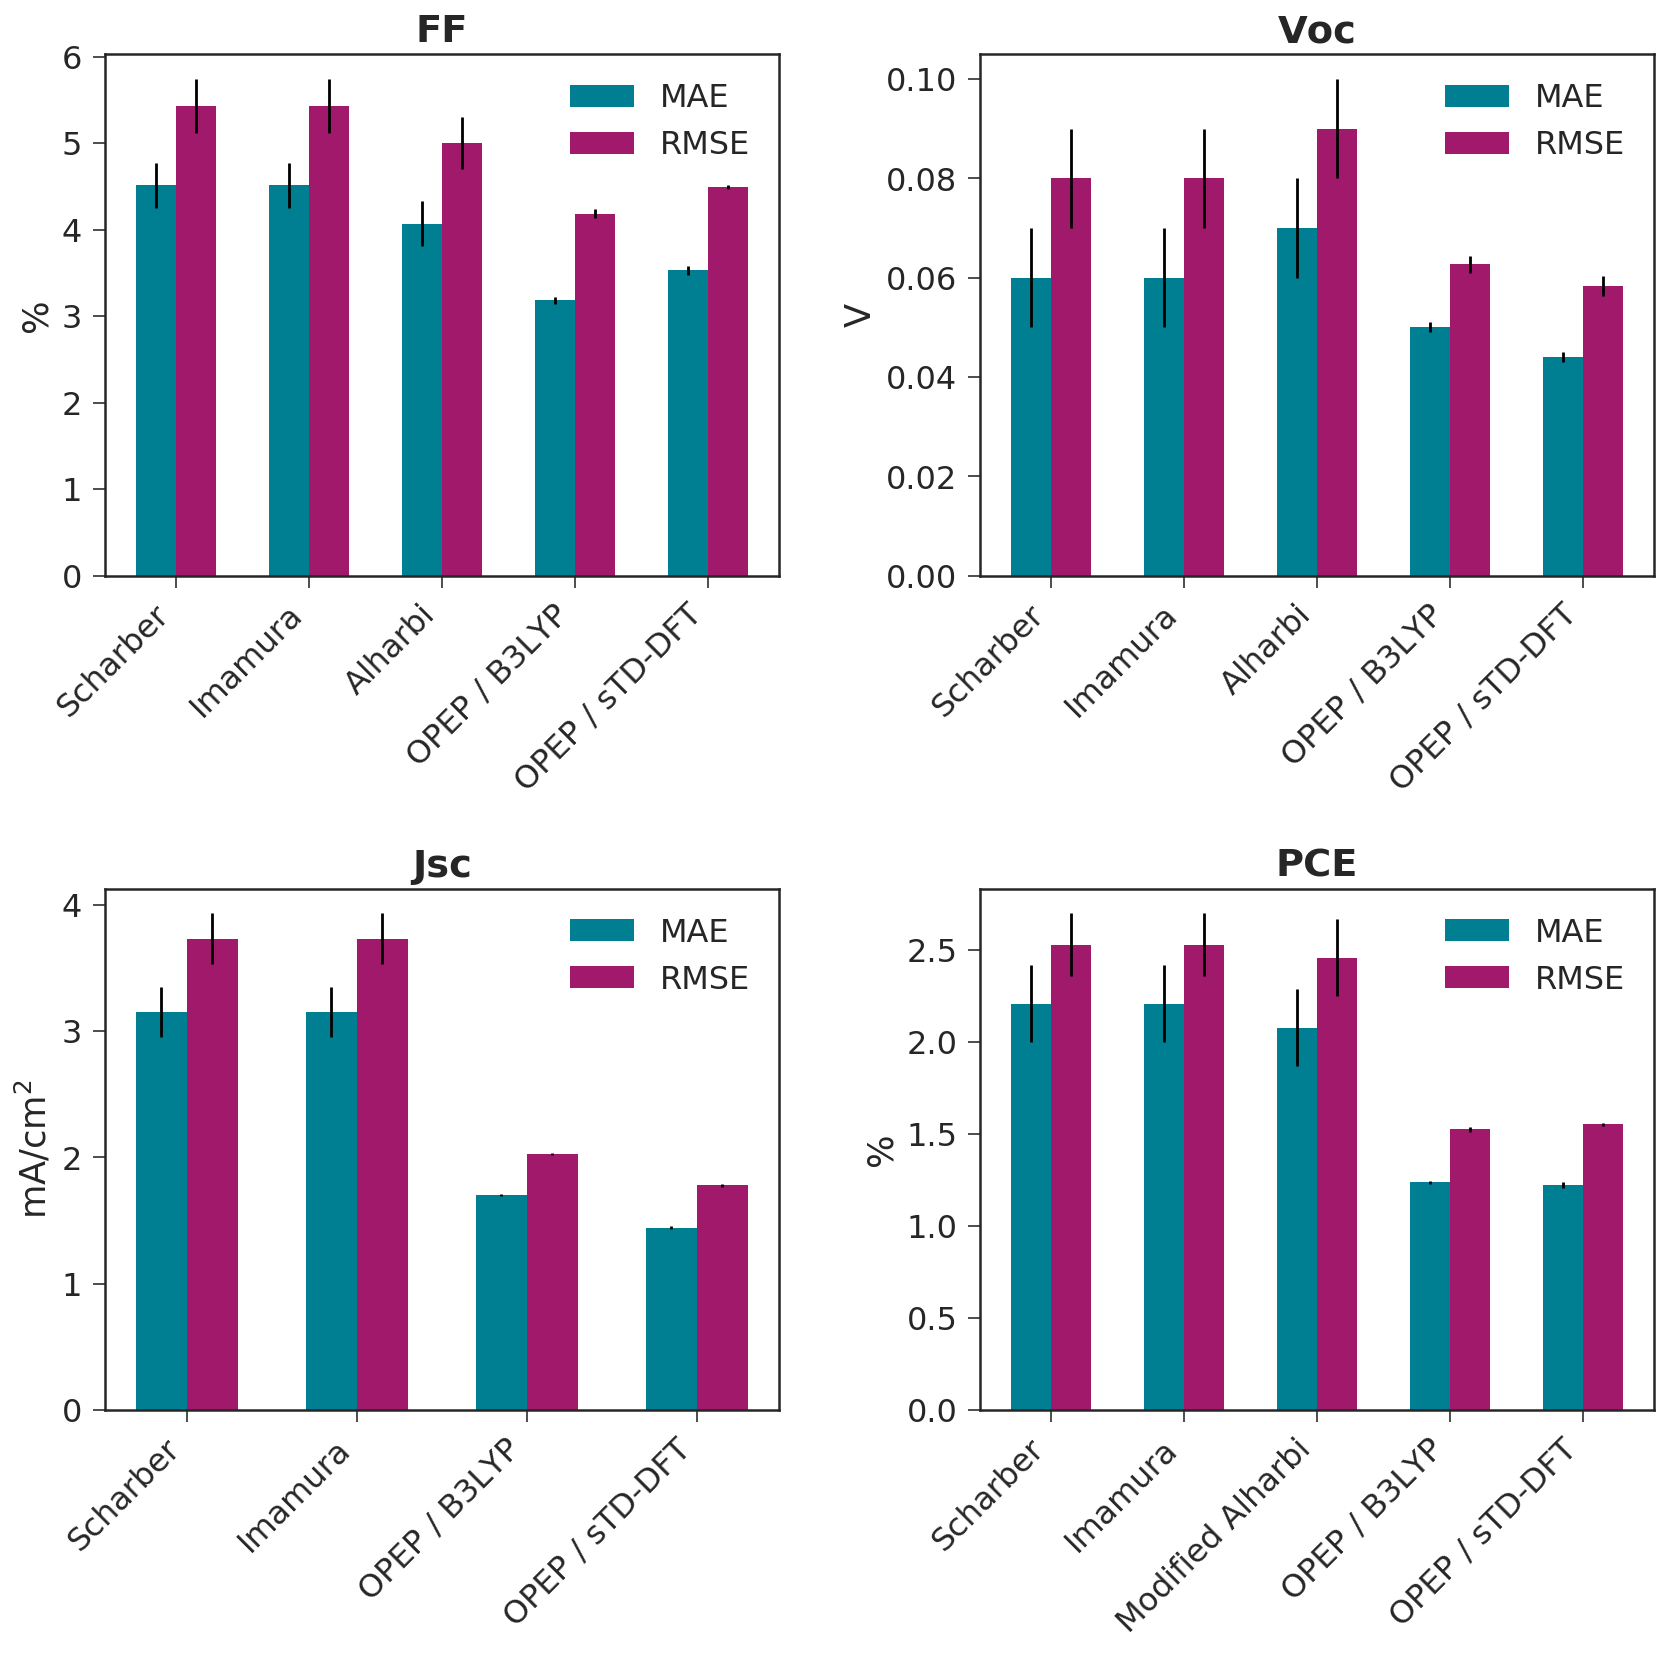

In [62]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12, 12))

make_barplots("FF", ax1)
make_barplots("Voc", ax2)
make_barplots("Jsc", ax3)
make_barplots("PCE", ax4)

ax1.set_ylabel('%')
ax2.set_ylabel('V')
ax3.set_ylabel('$\mathregular{mA/cm^{2}}$')
ax4.set_ylabel('%')

plt.tight_layout()
plt.subplots_adjust(top = 0.93, wspace = 0.3, hspace = 0.6)
plt.savefig('../figures/barplots_highPCE.png', dpi = 300)
plt.savefig('../figures/barplots_highPCE.svg', dpi=300)
plt.savefig('../figures/barplots_highPCE.pdf', dpi=300)
plt.show()

Creates a barplot of MAPE comparing the various models for FF, Voc, Jsc, and PCE for the models trained on high experimental PCE. Error bars are the standard error of the mean (SEM) of each model.

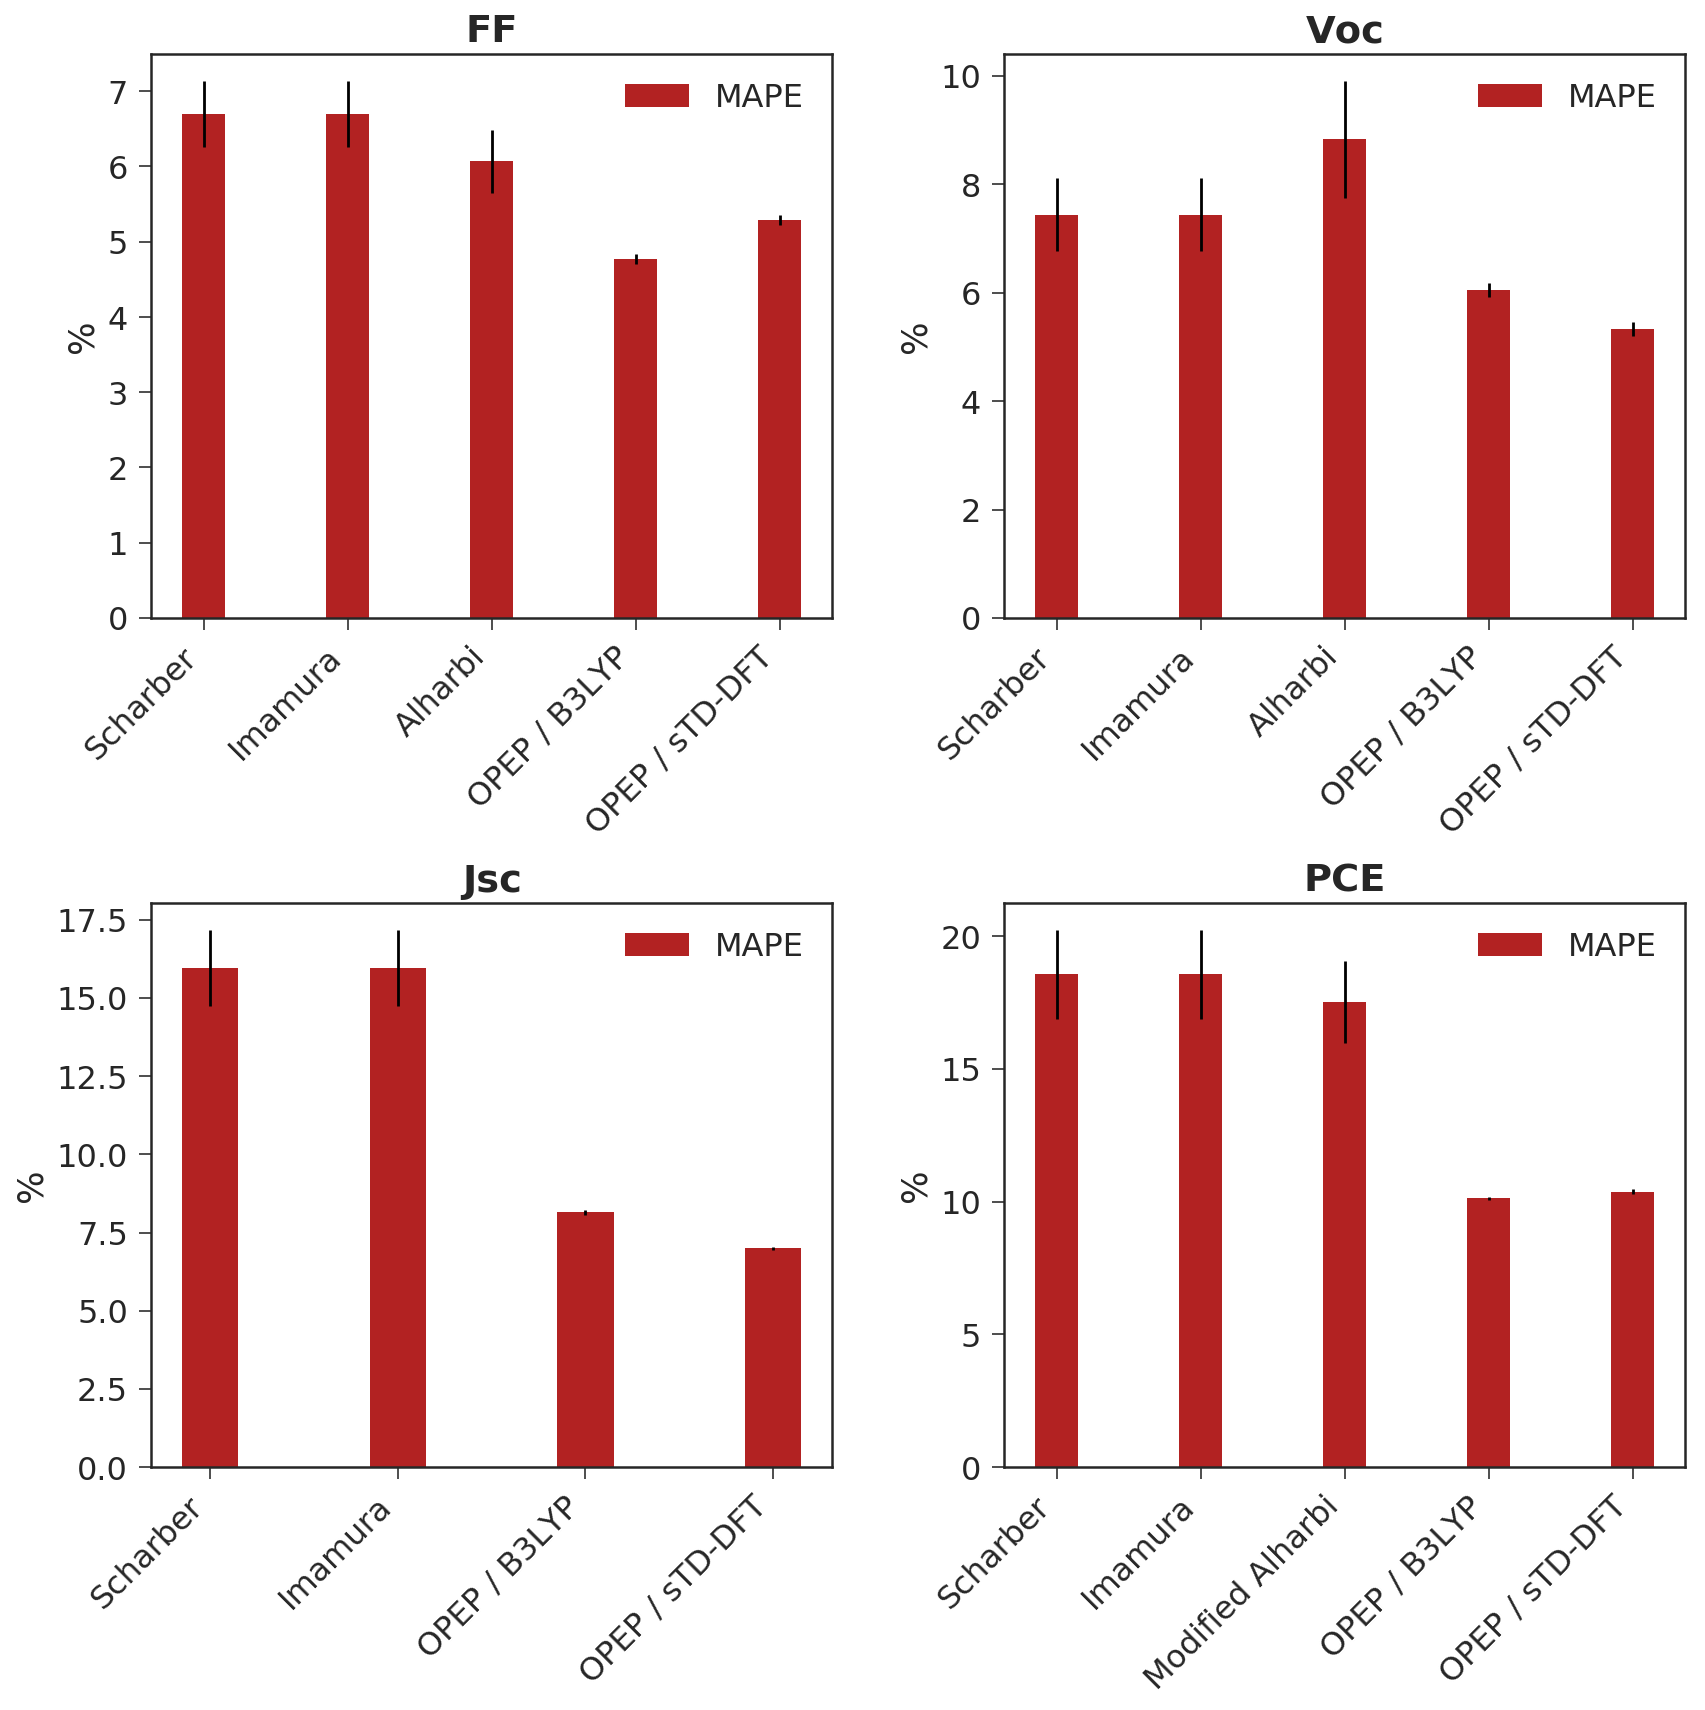

In [63]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12, 12))

make_barplots("FF", ax1, stat = 'MAPE')
make_barplots("Voc", ax2, stat = 'MAPE')
make_barplots("Jsc", ax3, stat = 'MAPE')
make_barplots("PCE", ax4, stat = 'MAPE')

ax1.set_ylabel('%')
ax2.set_ylabel('%')
ax3.set_ylabel('%')
ax4.set_ylabel('%')

plt.subplots_adjust(top = 0.93, wspace = 0.3, hspace = 0.4)
plt.tight_layout()
plt.savefig('../figures/barplots_MAPE_highPCE.png', dpi = 300)
plt.savefig('../figures/barplots_MAPE_highPCE.svg', dpi=300)
plt.savefig('../figures/barplots_MAPE_highPCE.pdf', dpi=300)

plt.show()

In [64]:
def make_scatter_plot(ax, feature, target, xlabel, ylabel, df=False, xyline=False, trendline=False):
    '''
    Creates a scatter plot comparing the predicted values to experimental values

    Parameters
    ---------
    ax: str
        axes on figure to plot it on
    feature: str
        Model name for predictions, as written in the dataframe. Example: 'ScharberPCEdon'
    target: str
        Values to compare to for y-axis, as written in the dataframe. Example: 'ExperimentalPCE'
    xlabel: str
        Name of model. Options are: 'Scharber PCE', 'Alharbi PCE', 'Imamura PCE', 'OPEP / B3LYP', 'OPEP / sTD-DFT'
    ylabel: str
        Label for y-axis
    df: boolean
        If True, values come from the df_highPCE dataframe
        If False, feature and target are just the names of the lists conatining the values 
    xyline: boolean
        If True, creates a 1:1 line with intercept 0
    trendline: boolean
        if True, draws a trendline
    '''
    
    if df ==True:
        x = df_highPCE[feature]
        y = df_highPCE[target]
    else:
        x = feature
        y = target
    
    ax.scatter(x, y, c='black')
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel)
    
    if xlabel == 'Scharber PCE':
        r2 = SchPCEdon_highPCE[0]
        r2_SEM = SchPCEdon_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.45, 0.85, text, fontsize = 'medium', transform=ax.transAxes)
    elif xlabel == 'Alharbi PCE':
        r2 = AlharbiPCEDon_highPCE[0]
        r2_SEM = AlharbiPCEDon_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.05, 0.4, text, fontsize = 'medium', transform=ax.transAxes)
    elif xlabel == 'Imamura PCE':
        r2 = ImamuraPCEdon_highPCE[0]
        r2_SEM = ImamuraPCEdon_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.45, 0.85, text, fontsize = 'medium', transform=ax.transAxes)
    elif xlabel == 'OPEP / B3LYP':
        r2 = OPEP_B3LYP_PCE_pred_highPCE[0]
        r2_SEM = OPEP_B3LYP_PCE_pred_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.05, 0.85, text, fontsize = 'medium', transform=ax.transAxes)
    elif xlabel == 'OPEP / sTD-DFT':
        r2 = OPEP_sTDDFT_PCE_pred_highPCE[0]
        r2_SEM = OPEP_sTDDFT_PCE_pred_highPCE[1]
        text = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
        ax.text(0.05, 0.85, text, fontsize = 'medium', transform=ax.transAxes)
    else:
        return "not valid model name"
    
    if trendline == True:
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot(x,p(x),"r--")
    
    if xyline == True:
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])  # max of both axes
        ]
        ax.plot(lims, lims, 'c--', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

"\n    if xyline == True:\n        lims = [\n        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes\n        np.max([ax.get_xlim(), ax.get_ylim()])  # max of both axes\n        ]\n        ax.plot(lims, lims, 'c--', alpha=0.75, zorder=0)\n        ax.set_aspect('equal')\n        ax.set_xlim(lims)\n        ax.set_ylim(lims)"

## Correlation plots for prediction models vs experimental values

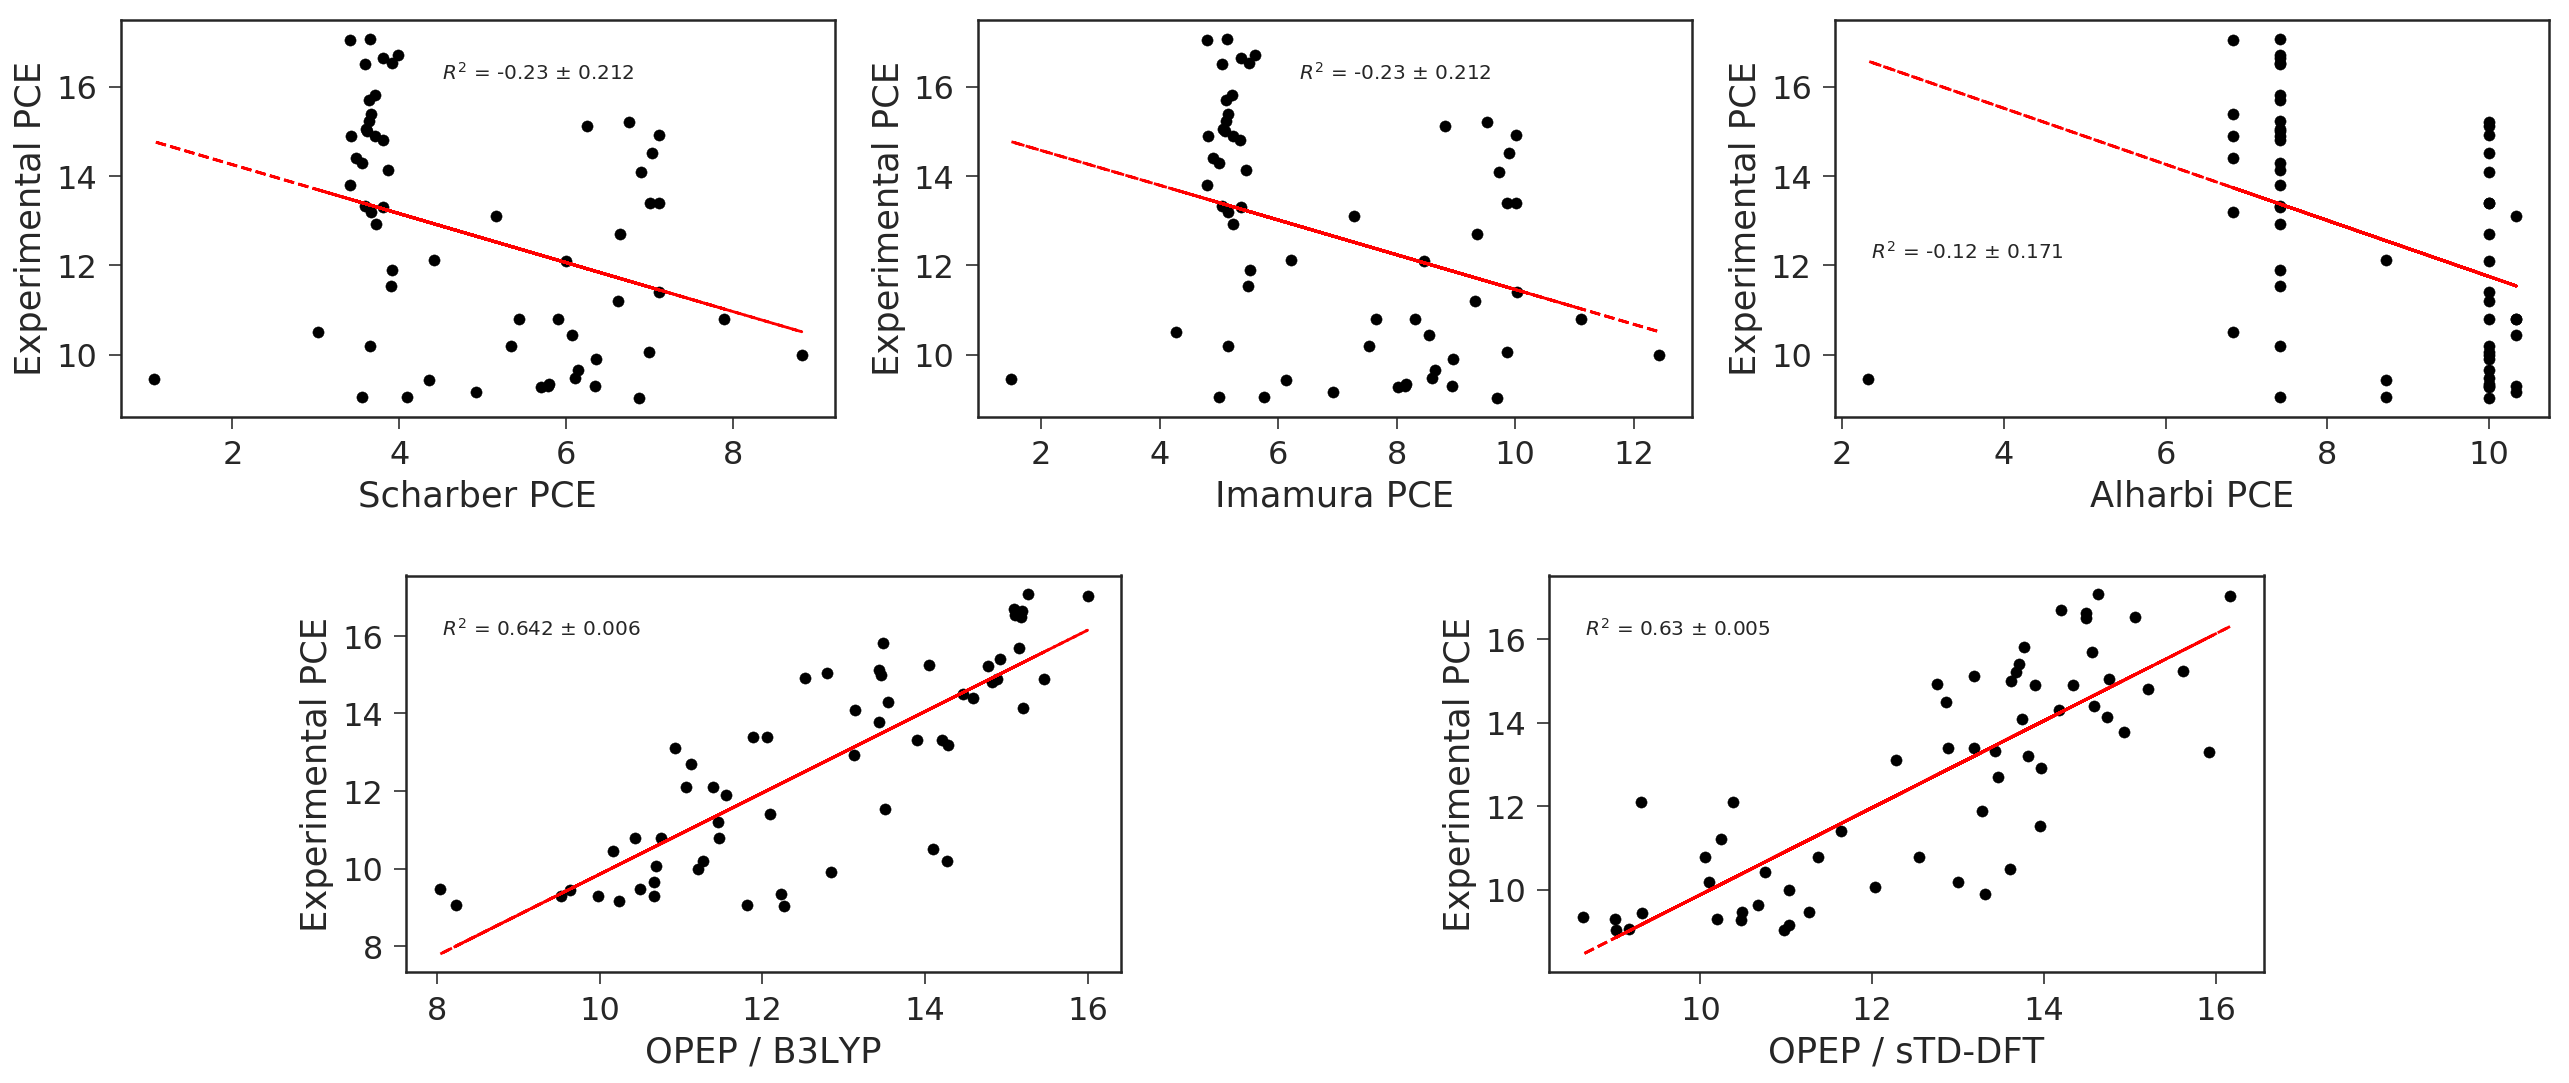

In [65]:
fig = plt.figure(figsize=(18, 8))

ax1 = plt.subplot2grid(shape=(2,9), loc=(0,0), colspan=3)
ax2 = plt.subplot2grid((2,9), (0,3), colspan=3)
ax3 = plt.subplot2grid((2,9), (0,6), colspan=3)
ax4 = plt.subplot2grid((2,9), (1,1), colspan=3)
ax5 = plt.subplot2grid((2,9), (1,5), colspan=3)

make_scatter_plot(ax1,'ScharberPCEdon', 'ExperimentalPCE', 'Scharber PCE', 'Experimental PCE',df = True, trendline=True)
make_scatter_plot(ax2,'ImamuraPCEdon', 'ExperimentalPCE', 'Imamura PCE', 'Experimental PCE', df  = True, trendline=True)
make_scatter_plot(ax3,'AlharbiPCEDon', 'ExperimentalPCE', 'Alharbi PCE', 'Experimental PCE', df  = True, trendline=True)
make_scatter_plot(ax4,LassoPCE_sTD_highPCE[-1], df_highPCE['ExperimentalPCE'], 'OPEP / B3LYP', 'Experimental PCE', trendline=True)
make_scatter_plot(ax5,LassoPCE_highPCE[-1], df_highPCE['ExperimentalPCE'], 'OPEP / sTD-DFT', 'Experimental PCE', trendline=True)

plt.tight_layout()
plt.subplots_adjust(top = 0.93, wspace = 1, hspace = 0.4)
plt.savefig('../figures/correlations_highPCE.svg')
plt.savefig('../figures/correlations_highPCE.png')
plt.savefig('../figures/correlations_highPCE.pdf')
plt.show()

(0.36, 0.078, 2.2799999999999998, 0.22, 2.9700000000000002, 0.28999999999999998, 34.850000000000001, 5.8300000000000001)
(0.3, 0.063, 2.3999999999999999, 0.22, 3.0699999999999998, 0.20000000000000001, 37.090000000000003, 5.5599999999999996)
(0.35, 0.080000000000000002, 2.3399999999999999, 0.23000000000000001, 2.98, 0.29999999999999999, 36.68, 5.9500000000000002)


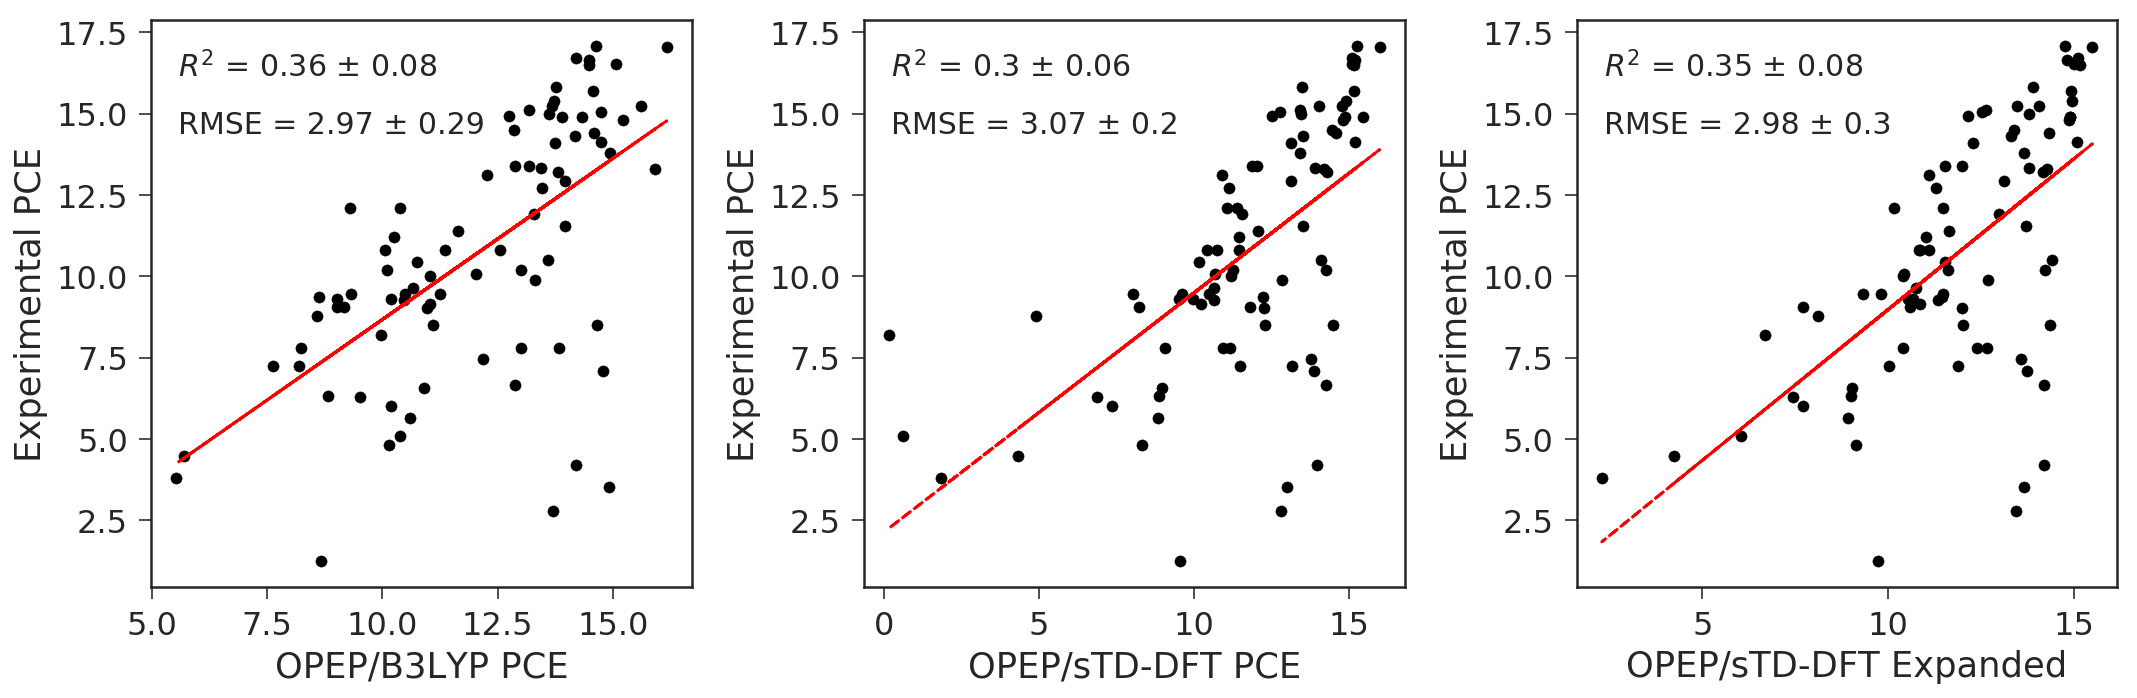

In [76]:
# scatter plots showing how the models (trained on high PCE), perform on all ranges of PCE
def CrossValModels(predicted, target):
    # predicted is the list of predicted values. Ex: df['ScharberPCEtotal'] or PerrisPCEcalc
    # target is the target experimental value. Ex: df['ExperimentalPCE']

    X = predicted
    y = target
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = 'r2')
    SEM_r2 = round((score.std() / math.sqrt(5)) , 3)
    #r2 = str(round(score.mean(), 3)) + ' +/- ' +  str(SEM_r2)
    r2 = round(float(score.mean()), 3)
    
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = 'neg_mean_absolute_error')
    score = np.multiply(score, -1)
    SEM_MAE = round((score.std() / math.sqrt(5)) , 2)
    #MAE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_MAE)
    MAE = round(score.mean(), 2) 
    
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = 'neg_mean_squared_error')
    score = np.sqrt(score * -1)
    SEM_RMSE = round((score.std() / math.sqrt(5)) , 2)
    #RMSE = str(round(score.mean(), 2)) + ' +/- ' +  str(SEM_RMSE)
    RMSE = round(score.mean(), 2)
    
    MAPE_scorer = make_scorer(mean_absolute_percentage_error)
    score = cross_val_score(SMWrapper(sm.OLS), X, y, cv=5, scoring = MAPE_scorer)
    score = score * 100
    SEM_MAPE = round((score.std() / math.sqrt(5)) , 2)
    MAPE = round(score.mean(), 2)

    return round(r2,2), SEM_r2, MAE, SEM_MAE, RMSE, SEM_RMSE, MAPE, SEM_MAPE

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))

sTDDFT_expanded_PCE = []
sTDDFT_PCE = []
B3LYP_PCE = []
experimental_PCE = []

for index, row in df.iterrows():
    sTDDFT_expanded_eq = -33.079899985 + (4.2551151709174313 * row['sTDDFTdeltaHOMO']) + (1.3773119416209663 * row['sTDDFTsummedoscs'])+ (-0.45867638953985362 * row['donsTDDFTsummedoscs'])+ (0.17352602219989174 * row['donsTDDFTabsFOM'])+ ( 2.449065076623004 * row['sTDDFTDonElectrodonating'])+ (0.0009507945724509905 * row['sTDDFTdonfirstengtranswavenumber'])
    sTDDFT_expanded_PCE.append(sTDDFT_expanded_eq)
    
    sTDDFT_eq = 99.8345577608 + (-7.5346772332273959 * row['sTDDFTdeltaLUMO']) + ( 5.4946743170844936 * row['sTDDFTdeltaHOMO']) + (-1.6636022959307213 * row['donsTDDFTdipolemoment']) + (1.5677462537650493 * row['sTDDFTsummedoscs']) + (0.097999426749019958 * row['donsTDDFTabsFOM']) + ( -0.0047307991771359317 * row['sTDDFTdonlowestengtranswavenumber'])
    sTDDFT_PCE.append(sTDDFT_eq)
    
    B3LYP_eq = -136.521585951 + (6.4223592219051397 * row['AccTriplet']) + ( 0.91736200720853223 * row['DeltaDipMom']) + (-0.00046578842135047271 * row['AccEnergyTransitionWavenumber']) + (-0.0036095492932883208 * row['Polarizability']) + (8.3069007344054988 * row['DonElectrodonating']) + ( 0.0038950158798875456 * row['don_lowest_transition_wavenumber'])
    B3LYP_PCE.append(B3LYP_eq)
    
    experimental_PCE.append(row['ExperimentalPCE'])
    
crossed_B3LYP = CrossValModels(B3LYP_PCE, experimental_PCE)
print(crossed_B3LYP)
crossed_sTDDFT = CrossValModels(sTDDFT_PCE, experimental_PCE)
print(crossed_sTDDFT)
crossed_sTDDFTexpanded = CrossValModels(sTDDFT_expanded_PCE, experimental_PCE)
print(crossed_sTDDFTexpanded)
    
ax1.scatter(B3LYP_PCE, experimental_PCE, c='black')
ax1.set_xlabel('OPEP/B3LYP PCE') 
ax1.set_ylabel('Experimental PCE')

# calc the trendline
z = np.polyfit(B3LYP_PCE, experimental_PCE, 1)
p = np.poly1d(z)
ax1.plot(B3LYP_PCE,p(B3LYP_PCE),"r--")

r2 = crossed_B3LYP[0]
r2_SEM = round(crossed_B3LYP[1], 2)
ax1textr2 = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
ax1.text(0.05, 0.9, ax1textr2, fontsize = 15, transform=ax1.transAxes)
rmse = round(crossed_B3LYP[4], 2)
rmse_SEM = round(crossed_B3LYP[5], 2)
ax1textrmse = 'RMSE = ' + str(rmse) + ' ' + u"\u00B1" + ' ' + str(rmse_SEM)
ax1.text(0.05, 0.8, ax1textrmse, fontsize = 15, transform=ax1.transAxes)

ax2.scatter(sTDDFT_PCE, experimental_PCE, c='black')
ax2.set_xlabel('OPEP/sTD-DFT PCE') 
ax2.set_ylabel('Experimental PCE')

# calc the trendline
z = np.polyfit(sTDDFT_PCE, experimental_PCE, 1)
p = np.poly1d(z)
ax2.plot(sTDDFT_PCE,p(sTDDFT_PCE),"r--")

r2 = crossed_sTDDFT[0]
r2_SEM = round(crossed_sTDDFT[1], 2)
ax2textr2 = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
ax2.text(0.05, 0.9, ax2textr2, fontsize = 15, transform=ax2.transAxes)
rmse = round(crossed_sTDDFT[4], 2)
rmse_SEM = round(crossed_sTDDFT[5], 2)
ax2textrmse = 'RMSE = ' + str(rmse) + ' ' + u"\u00B1" + ' ' + str(rmse_SEM)
ax2.text(0.05, 0.8, ax2textrmse, fontsize = 15, transform=ax2.transAxes)


ax3.scatter(sTDDFT_expanded_PCE, experimental_PCE, c='black')
ax3.set_xlabel('OPEP/sTD-DFT Expanded') 
ax3.set_ylabel('Experimental PCE')

# calc the trendline
z = np.polyfit(sTDDFT_expanded_PCE, experimental_PCE, 1)
p = np.poly1d(z)
ax3.plot(sTDDFT_expanded_PCE,p(sTDDFT_expanded_PCE),"r--")

r2 = crossed_sTDDFTexpanded[0]
r2_SEM = round(crossed_sTDDFTexpanded[1], 2)
ax2textr2 = '$R^2$ = ' + str(r2) + ' ' + u"\u00B1" + ' ' + str(r2_SEM)
ax3.text(0.05, 0.9, ax2textr2, fontsize = 15, transform=ax3.transAxes)
rmse = round(crossed_sTDDFTexpanded[4], 2)
rmse_SEM = round(crossed_sTDDFTexpanded[5], 2)
ax2textrmse = 'RMSE = ' + str(rmse) + ' ' + u"\u00B1" + ' ' + str(rmse_SEM)
ax3.text(0.05, 0.8, ax2textrmse, fontsize = 15, transform=ax3.transAxes)


plt.tight_layout()
plt.savefig('../figures/correlation_highPCEmodels_vs_allPCE.png')
plt.savefig('../figures/correlation_highPCEmodels_vs_allPCE.pdf', dpi=300)

plt.show()

## T-Test comparing the various models

Create arrays of PCE of each model trained on high PCE on high PCE dataset

In [84]:
sTDDFT_expanded_PCE = []
sTDDFT_PCE = []
B3LYP_PCE = []

for index, row in df_highPCE.iterrows():
    sTDDFT_expanded_eq = -33.079899985 + (4.2551151709174313 * row['sTDDFTdeltaHOMO']) + (1.3773119416209663 * row['sTDDFTsummedoscs'])+ (-0.45867638953985362 * row['donsTDDFTsummedoscs'])+ (0.17352602219989174 * row['donsTDDFTabsFOM'])+ ( 2.449065076623004 * row['sTDDFTDonElectrodonating'])+ (0.0009507945724509905 * row['sTDDFTdonfirstengtranswavenumber'])
    sTDDFT_expanded_PCE.append(sTDDFT_expanded_eq)
    
    sTDDFT_eq = 99.8345577608 + (-7.5346772332273959 * row['sTDDFTdeltaLUMO']) + ( 5.4946743170844936 * row['sTDDFTdeltaHOMO']) + (-1.6636022959307213 * row['donsTDDFTdipolemoment']) + (1.5677462537650493 * row['sTDDFTsummedoscs']) + (0.097999426749019958 * row['donsTDDFTabsFOM']) + ( -0.0047307991771359317 * row['sTDDFTdonlowestengtranswavenumber'])
    sTDDFT_PCE.append(sTDDFT_eq)
    
    B3LYP_eq = -136.521585951 + (6.4223592219051397 * row['AccTriplet']) + ( 0.91736200720853223 * row['DeltaDipMom']) + (-0.00046578842135047271 * row['AccEnergyTransitionWavenumber']) + (-0.0036095492932883208 * row['Polarizability']) + (8.3069007344054988 * row['DonElectrodonating']) + ( 0.0038950158798875456 * row['don_lowest_transition_wavenumber'])
    B3LYP_PCE.append(B3LYP_eq)

[10.756551825457606, 12.75434988071504, 13.62282077728986, 13.190966037634752, 14.564081933126573, 16.173217926354482, 15.622018101214934, 10.471869847742312, 13.74480678296311, 12.862448878584587, 14.195819563618841, 12.280129467548406, 13.714932550259277, 14.489112798242161, 10.970679004777338, 10.195272907939938, 9.0105161049841769, 14.178699374614865, 14.489006271443799, 11.261384228917748, 13.774093626666343, 10.66744838541112, 12.028624846259021, 15.215896261393311, 13.315641673719568, 10.094924213912378, 13.60431479481403, 11.027050001341877, 10.376563646289895, 12.548406957853061, 13.675458301164639, 15.918639134819841, 11.028850552730731, 10.057696769240025, 14.755607856957965, 14.340722301841453, 9.3045577423756356, 15.063437773291412, 14.62867411161713, 14.739811747836285, 13.970182015407261, 14.932870933557098, 10.241708458499829, 11.641522043995622, 8.6271602029418659, 10.489334182699139, 13.957185499943222, 11.36961037863594, 12.88532839515841, 13.460663658099634, 9.17204

In [82]:
stats.ttest_ind(B3LYP_PCE, sTDDFT_PCE)

Ttest_indResult(statistic=-0.022873601031484191, pvalue=0.98178973320229002)

In [83]:
stats.ttest_ind(sTDDFT_PCE,sTDDFT_expanded_PCE)

Ttest_indResult(statistic=0.15063209396240959, pvalue=0.8805231364877768)

## Plots to compare models

In [67]:
def AbsoluteError(predicted, experimental, percent_error = False):
    # predicted is the predicted values. Ex: df['ScharberFF']
    # experimental is the target experimental values. Ex: df['ExperimentalFF']
    # returns are list of errors
    
    absolute_errors = []
    for x in range(len(experimental)):
        if percent_error == True:
            absolute_errors.append(((predicted[x] - experimental[x])/experimental[x])*100)
        else:
            absolute_errors.append(predicted[x] - experimental[x])
    return absolute_errors

def make_violinplot(ax, error_list, label_list, title, matchcolor=False):
    # ax is which axes on the figure you want. Ex: ax1
    # error_list is the list of deviations Ex. FF_err_list
    # label_list is the list of labels for x-axis. Make sure it is same order as error_list
    # y_min and y_max are the limits for the y-axis
    # title is a string for subplot titles. Ex: 'FF'
    #
    # returns a plt object

    ax.grid(b = True, axis = 'y', ls = '--')
    ax.axhline(y = 0, color = 'dimgrey', linestyle = ':')
    
    if matchcolor==True:
        if title == 'Jsc':
            Jsc_palette = [sns.husl_palette(10)[0], sns.husl_palette(10)[2], sns.husl_palette(10)[6], sns.husl_palette(10)[8]]
            sns.violinplot(data = error_list, showextrema = True, showmedians = True, palette = Jsc_palette, ax = ax)
        else:
            sns.violinplot(data = error_list, showextrema = True, showmedians = True, palette = 'husl', ax = ax)
    else:
        sns.violinplot(data = error_list, showextrema = True, showmedians = True, palette = 'husl', ax = ax)
    ax.set_xticklabels(label_list, rotation = 45, ha = 'right')
    ax.set_title(title, weight = 'bold')
    if title == 'FF':
        ax.set_ylabel('Deviation (%)')
    elif title == 'Voc':
        ax.set_ylabel('Deviation (V)')
    elif title == 'Jsc':
        ax.set_ylabel('Deviation ($\mathregular{mA/cm^{2}}$)')
    elif title == 'PCE':
        ax.set_ylabel('Deviation (%)')
    
    return plt


### Violin plot of FF, Voc, Jsc, and PCE with deviations (predicted - experimental) for all PCEs

In [68]:
ScharberFFerr = AbsoluteError(df['ScharberFF'], df['ExperimentalFF'])
AlharbiFFDonerr = AbsoluteError(df['AlharbiFFDon'], df['ExperimentalFF'])
AlharbiFFAccerr = AbsoluteError(df['AlharbiFFAcc'], df['ExperimentalFF'])
ImamuraFFerr = AbsoluteError(df['ImamuraFF'], df['ExperimentalFF'])
OPEP_B3LYP_FF_err = AbsoluteError(LassoFF[-1], df['ExperimentalFF'])
OPEP_sTDDFT_FF_err = AbsoluteError(LassoFF_sTD[-1], df['ExperimentalFF'])
OPEP_sTDDFT_Expanded_FF_err = AbsoluteError(LassoFF_sTD_all[-1], df_sTD['ExperimentalFF'])

FF_err_list = [ScharberFFerr, ImamuraFFerr, AlharbiFFDonerr, AlharbiFFAccerr,  OPEP_B3LYP_FF_err, OPEP_sTDDFT_FF_err, OPEP_sTDDFT_Expanded_FF_err]
FF_list = ['Scharber','Imamura', 'Alharbi (Don)', 'Alharbi (Acc)', 'OPEP / B3LYP', 'OPEP / sTD-DFT', 'OPEP / sTD-DFT Expanded']


AlharbiVocAccErr = AbsoluteError(df['AlharbiVocAcc'], df['ExperimentalVoc'])
AlharbiVocDonErr = AbsoluteError(df['AlharbiVocDon'], df['ExperimentalVoc'])
ImamuraVocErr = AbsoluteError(df['ImamuraVoc'], df['ExperimentalVoc'])
ScharberVocErr = AbsoluteError(df['ScharberVoc'], df['ExperimentalVoc'])
OPEP_B3LYP_Voc_err = AbsoluteError(LassoVoc[-1], df['ExperimentalVoc'])
OPEP_sTDDFT_Voc_err = AbsoluteError(LassoVoc_sTD[-1], df['ExperimentalVoc'])
OPEP_sTDDFT_Expanded_Voc_err = AbsoluteError(LassoVoc_sTD_all[-1], df_sTD['ExperimentalVoc'])

Voc_err_list = [ScharberVocErr,ImamuraVocErr, AlharbiVocDonErr, AlharbiVocAccErr, OPEP_B3LYP_Voc_err, OPEP_sTDDFT_Voc_err, OPEP_sTDDFT_Expanded_Voc_err]
Voc_list = ['Scharber','Imamura','Alharbi (Don)', 'Alharbi (Acc)', 'OPEP / B3LYP', 'OPEP / sTD-DFT', 'OPEP / sTD-DFT Expanded']


ScharberJscAccErr = AbsoluteError(df['ScharberJscAcc'], df['ExperimentalJsc'])
ImamuraTotalJscErr = AbsoluteError(df['ImamuraTotalJsc'], df['ExperimentalJsc'])
ImamuraJscAccErr = AbsoluteError(df['ImamuraJscAcc'], df['ExperimentalJsc'])
ImamuraJscDonErr = AbsoluteError(df['ImamuraJscDon'], df['ExperimentalJsc'])
ScharberTotalJscErr = AbsoluteError(df['ScharberTotalJsc'], df['ExperimentalJsc'])
ScharberJscDonErr = AbsoluteError(df['ScharberJscDon'], df['ExperimentalJsc'])
ScharberJsclowestoptbgErr = AbsoluteError(df['ScharberJsclowestoptbg'], df['ExperimentalJsc'])
OPEP_B3LYP_Jsc_err = AbsoluteError(LassoJsc[-1], df['ExperimentalJsc'])
OPEP_sTDDFT_Jsc_err = AbsoluteError(LassoJsc_sTD[-1], df['ExperimentalJsc'])
OPEP_sTDDFT_Expanded_Jsc_err = AbsoluteError(LassoJsc_sTD_all[-1], df_sTD['ExperimentalJsc'])

Jsc_err_list = [ScharberJscDonErr,ScharberJscAccErr, ScharberTotalJscErr, ScharberJsclowestoptbgErr, ImamuraJscDonErr,ImamuraJscAccErr, ImamuraTotalJscErr, OPEP_B3LYP_Jsc_err, OPEP_sTDDFT_Jsc_err, OPEP_sTDDFT_Expanded_Jsc_err]
Jsc_list = ['Scharber (Don)', 'Scharber (Acc)', 'Scharber (Total)', 'Scharber (Low Eg)', 'Imamura (Don)','Imamura (Acc)','Imamura (Total)', 'OPEP / B3LYP', 'OPEP / sTD-DFT', 'OPEP / sTD-DFT Expanded']


SchPCEdonErr = AbsoluteError(df['ScharberPCEdon'], df['ExperimentalPCE'])
SchPCEaccErr = AbsoluteError(df['ScharberPCEacc'], df['ExperimentalPCE'])
SchPCEtotalErr = AbsoluteError(df['ScharberPCEtotal'], df['ExperimentalPCE'])
SchPCElowbgErr = AbsoluteError(df['ScharberPCElowestoptbg'], df['ExperimentalPCE'])
ImamuraPCEdonErr = AbsoluteError(df['ImamuraPCEdon'], df['ExperimentalPCE'])
ImamuraPCEaccErr = AbsoluteError(df['ImamuraPCEacc'], df['ExperimentalPCE'])
ImamuraPCEtotErr = AbsoluteError(df['ImamuraPCEtotal'], df['ExperimentalPCE'])
AlharbiPCEDonErr = AbsoluteError(df['AlharbiPCEDon'], df['ExperimentalPCE'])
AlharbiPCEAccErr = AbsoluteError(df['AlharbiPCEAcc'], df['ExperimentalPCE'])
OPEP_B3LYP_PCE_pred_err = AbsoluteError(LassoPCE[-1], df['ExperimentalPCE'])
OPEP_sTDDFT_PCE_pred_err = AbsoluteError(LassoPCE_sTD[-1], df['ExperimentalPCE'])
OPEP_sTDDFT_Expanded_PCE_pred_err = AbsoluteError(LassoPCE_sTD_all[-1], df_sTD['ExperimentalPCE'])
OPEP_B3LYP_PCE_calc_err = AbsoluteError(OPEP_B3LYP_PCE_Calc, df['ExperimentalPCE'])
OPEP_B3LYP_PCE_FF70_err = AbsoluteError(OPEP_B3LYP_PCE_FF70, df['ExperimentalPCE'])
OPEP_sTDDFT_PCE_calc_err = AbsoluteError(OPEP_sTDDFT_PCE_calc, df['ExperimentalPCE'])
OPEP_sTDDFT_PCE_FF70_err = AbsoluteError(OPEP_sTDDFT_PCE_FF70, df['ExperimentalPCE'])
OPEP_sTDDFT_Expanded_PCE_calc_err = AbsoluteError(OPEP_sTDDFT_PCE_calc_expanded, df_sTD['ExperimentalPCE'])
OPEP_sTDDFT_Expanded_PCE_FF70_err = AbsoluteError(OPEP_sTDDFT_PCE_FF70_expanded, df_sTD['ExperimentalPCE'])

PCE_err_list = [SchPCEdonErr, SchPCEaccErr, SchPCEtotalErr,SchPCElowbgErr, ImamuraPCEdonErr,ImamuraPCEaccErr, ImamuraPCEtotErr, AlharbiPCEDonErr, AlharbiPCEAccErr, OPEP_B3LYP_PCE_pred_err, OPEP_sTDDFT_PCE_pred_err, OPEP_sTDDFT_Expanded_PCE_pred_err, OPEP_B3LYP_PCE_calc_err, OPEP_sTDDFT_PCE_calc_err, OPEP_sTDDFT_Expanded_PCE_calc_err]
PCE_list = ['Scharber (Don)', 'Scharber (Acc)', 'Scharber (total)', 'Scharber (lowest Eg)', 'Imamura (Don)', 'Imamura (Acc)', 'Imamura (total)', 'modified Alharbi (Don)', 'modified Alharbi (Acc)', 'OPEP / B3LYP' , 'OPEP / sTD-DFT', 'OPEP / sTD-DFT Expanded', 'OPEP / B3LYP (calc.)', 'OPEP / sTD-DFT (calc.)', 'OPEP / sTD-DFT Expanded (calc.)' ]

### Violin plots of FF, Voc, Jsc, and PCE with deviations for any experimental PCE

/ihome/crc/install/python/anaconda3.5-4.2.0/lib/python3.5/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/ihome/crc/install/python/anaconda3.5-4.2.0/lib/python3.5/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


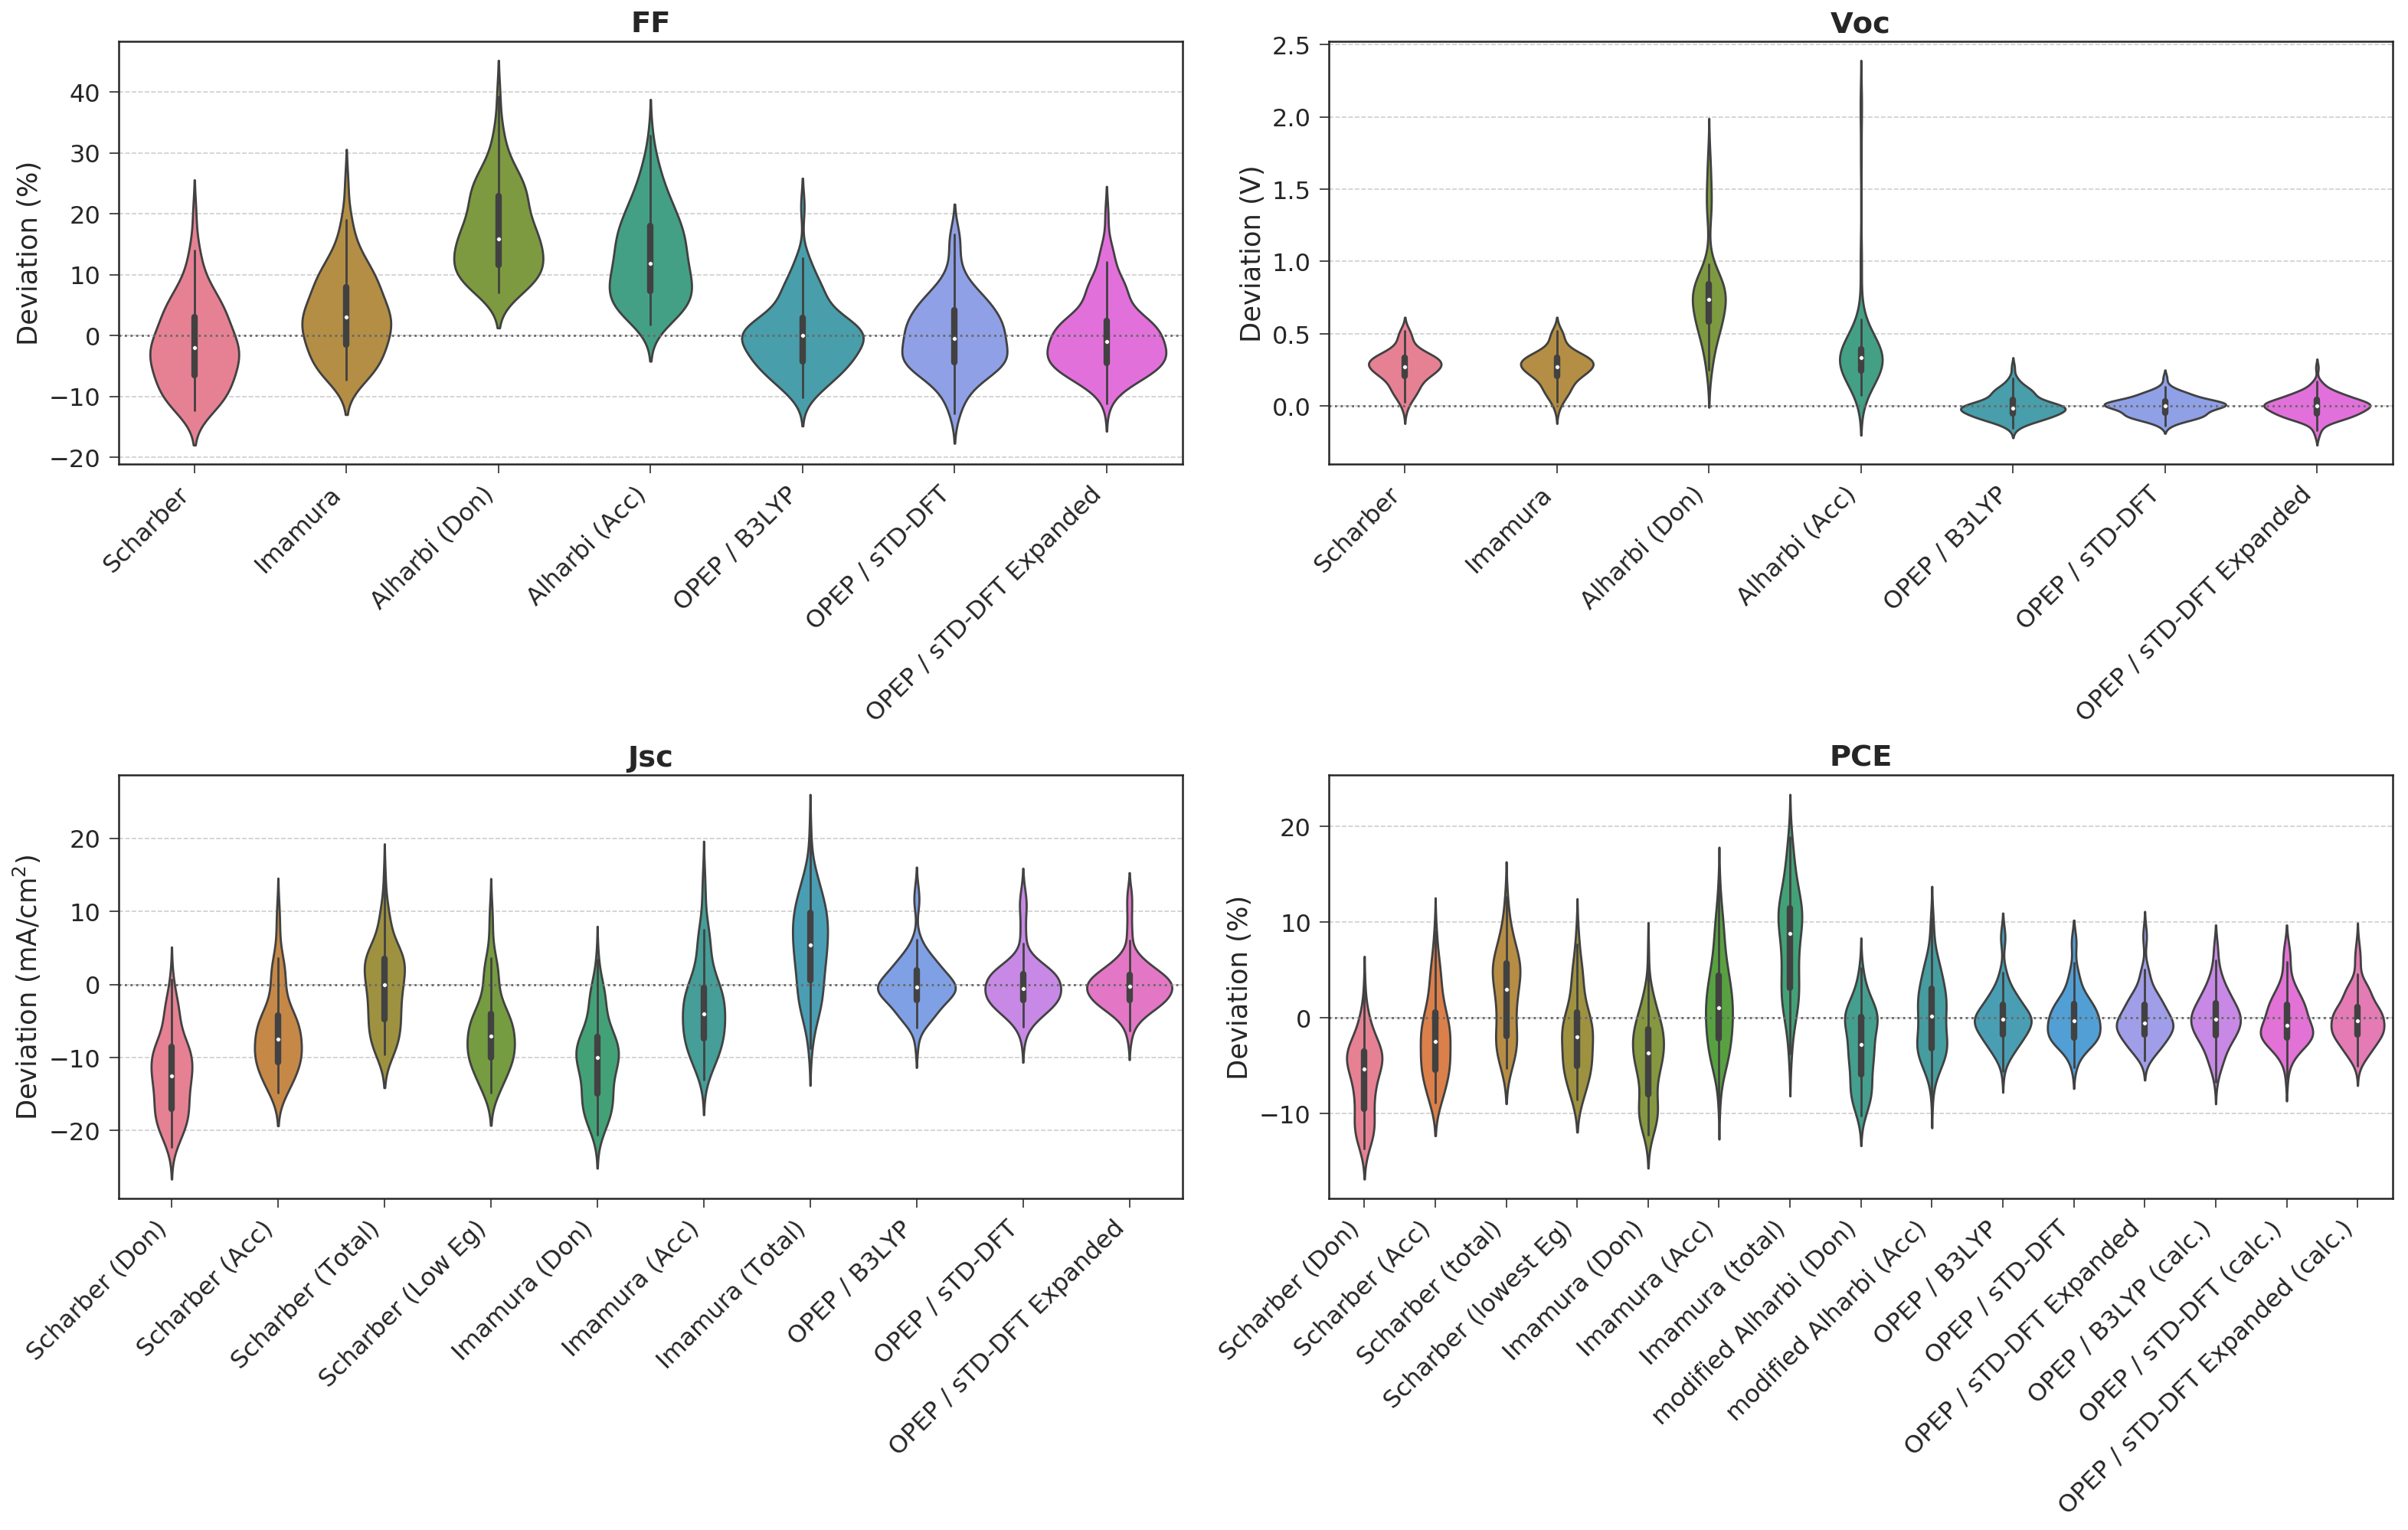

In [69]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (22, 14))

make_violinplot(ax1,FF_err_list, FF_list, 'FF' )
make_violinplot(ax2, Voc_err_list, Voc_list, 'Voc')
make_violinplot(ax3, Jsc_err_list, Jsc_list, 'Jsc')
make_violinplot(ax4, PCE_err_list, PCE_list,'PCE')

#plt.subplots_adjust(top = 0.95, bottom = 0.05, wspace = 0.2, hspace = 0.85)
plt.tight_layout()
plt.savefig('../figures/violinplots_all_models.pdf', dpi=300)
plt.savefig('../figures/violinplots_all_models.png', dpi = 300)
plt.show()

### Violin plots of FF, Voc, Jsc, and PCE with deviations for experimetnal PCEs > 9%

In [70]:
ScharberFFerr = AbsoluteError(df_highPCE['ScharberFF'], df_highPCE['ExperimentalFF'])
AlharbiFFDonerr = AbsoluteError(df_highPCE['AlharbiFFDon'], df_highPCE['ExperimentalFF'])
ImamuraFFerr = AbsoluteError(df_highPCE['ImamuraFF'], df_highPCE['ExperimentalFF'])
OPEP_B3LYP_FF_err = AbsoluteError(LassoFF_highPCE[-1], df_highPCE['ExperimentalFF'])
OPEP_sTDDFT_FF_err = AbsoluteError(LassoFF_sTD_highPCE[-1], df_highPCE['ExperimentalFF'])

FF_err_list_highPCE = [ScharberFFerr,ImamuraFFerr, AlharbiFFDonerr, OPEP_B3LYP_FF_err, OPEP_sTDDFT_FF_err]
FF_list = ['Scharber', 'Imamura', 'Alharbi','OPEP / B3LYP', 'OPEP / sTD-DFT']


AlharbiVocDonErr = AbsoluteError(df_highPCE['AlharbiVocDon'], df_highPCE['ExperimentalVoc'])
ImamuraVocErr = AbsoluteError(df_highPCE['ImamuraVoc'], df_highPCE['ExperimentalVoc'])
ScharberVocErr = AbsoluteError(df_highPCE['ScharberVoc'], df_highPCE['ExperimentalVoc'])
OPEP_B3LYP_Voc_err = AbsoluteError(LassoVoc_highPCE[-1], df_highPCE['ExperimentalVoc'])
OPEP_sTDDFT_Voc_err = AbsoluteError(LassoVoc_sTD_highPCE[-1], df_highPCE['ExperimentalVoc'])

Voc_err_list_highPCE = [ScharberVocErr, ImamuraVocErr, AlharbiVocDonErr, OPEP_B3LYP_Voc_err, OPEP_sTDDFT_Voc_err]
Voc_list = ['Scharber', 'Imamura', 'Alharbi', 'OPEP / B3LYP', 'OPEP / sTD-DFT']


ImamuraJscDonErr = AbsoluteError(df_highPCE['ImamuraJscDon'], df_highPCE['ExperimentalJsc'])
ScharberJscDonErr = AbsoluteError(df_highPCE['ScharberJscDon'], df_highPCE['ExperimentalJsc'])
OPEP_B3LYP_Jsc_err = AbsoluteError(LassoJsc_highPCE[-1], df_highPCE['ExperimentalJsc'])
OPEP_sTDDFT_Jsc_err = AbsoluteError(LassoJsc_sTD_highPCE[-1], df_highPCE['ExperimentalJsc'])

Jsc_err_list_highPCE = [ScharberJscDonErr, ImamuraJscDonErr, OPEP_B3LYP_Jsc_err, OPEP_sTDDFT_Jsc_err]
Jsc_list = ['Scharber', 'Imamura', 'OPEP / B3LYP', 'OPEP / sTD-DFT']


SchPCEdonErr = AbsoluteError(df_highPCE['ScharberPCEdon'], df_highPCE['ExperimentalPCE']) 
ImamuraPCEdonErr = AbsoluteError(df_highPCE['ImamuraPCEdon'], df_highPCE['ExperimentalPCE'])
AlharbiPCEDonErr = AbsoluteError(df_highPCE['AlharbiPCEDon'], df_highPCE['ExperimentalPCE'])
OPEP_B3LYP_PCE_err = AbsoluteError(LassoPCE_highPCE[-1], df_highPCE['ExperimentalPCE'])
OPEP_sTDDFT_PCE_err = AbsoluteError(LassoPCE_sTD_highPCE[-1], df_highPCE['ExperimentalPCE'])
OPEP_sTDDFT_Expanded_PCE_err = AbsoluteError(LassoPCE_sTD_highPCE_all[-1], df_sTD_highPCE['ExperimentalPCE'])

PCE_err_list_highPCE = [SchPCEdonErr, ImamuraPCEdonErr,AlharbiPCEDonErr, OPEP_B3LYP_PCE_err, OPEP_sTDDFT_PCE_err]
PCE_list = ['Scharber', 'Imamura', 'Modified Alharbi', 'OPEP / B3LYP' , 'OPEP / sTD-DFT']

/ihome/crc/install/python/anaconda3.5-4.2.0/lib/python3.5/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/ihome/crc/install/python/anaconda3.5-4.2.0/lib/python3.5/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


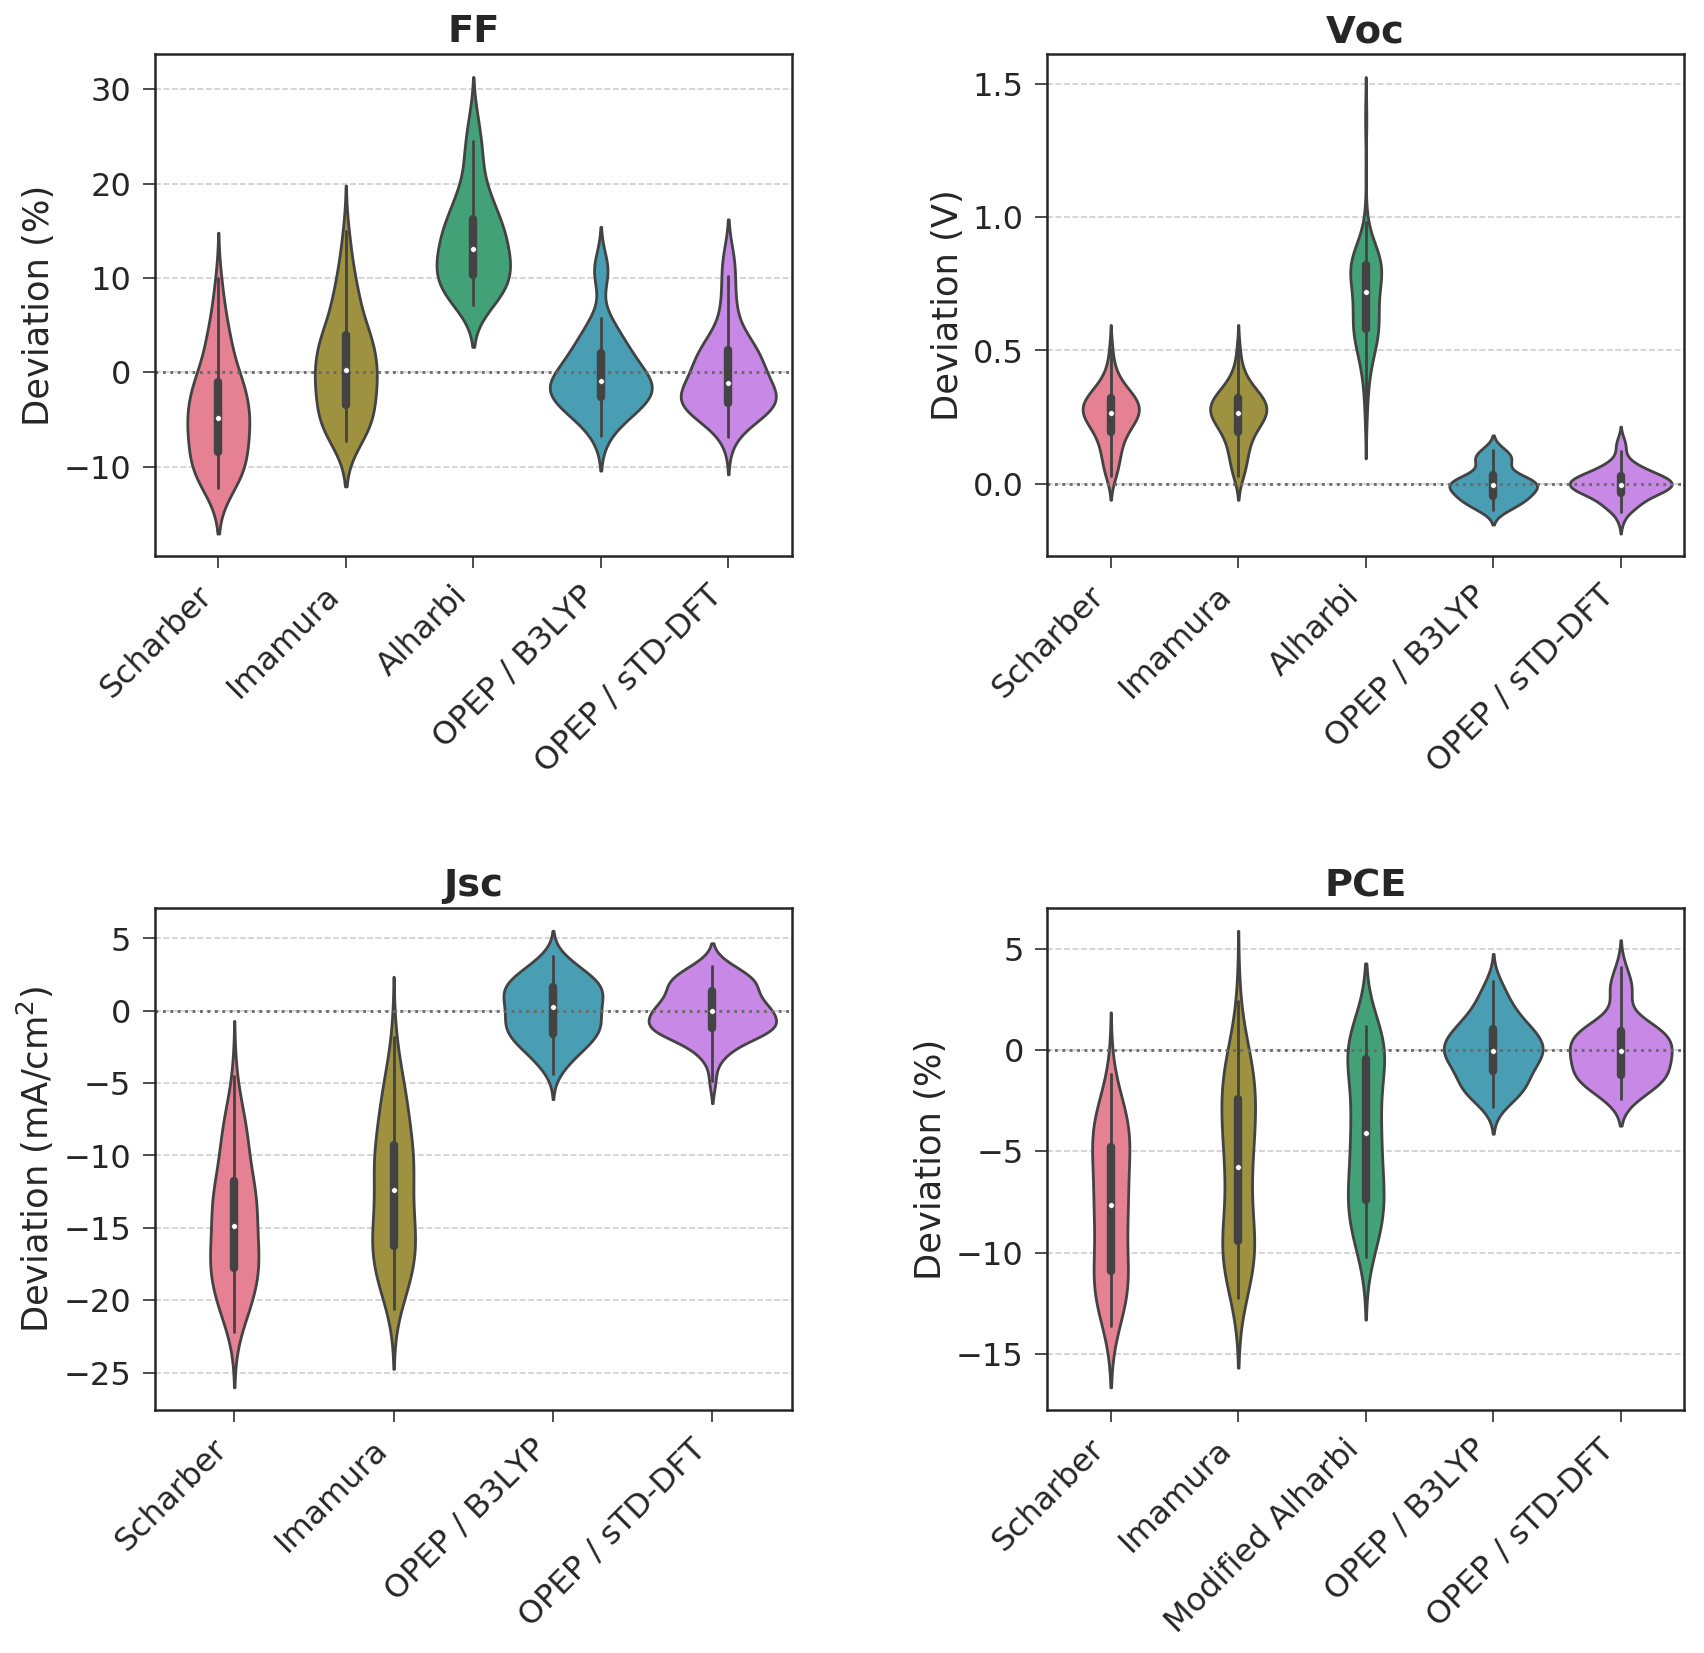

In [71]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12, 12))

make_violinplot(ax1,FF_err_list_highPCE, FF_list, 'FF' )
make_violinplot(ax2, Voc_err_list_highPCE, Voc_list, 'Voc')
make_violinplot(ax3, Jsc_err_list_highPCE, Jsc_list, 'Jsc', matchcolor = True)
make_violinplot(ax4, PCE_err_list_highPCE, PCE_list,'PCE')

plt.tight_layout()
plt.subplots_adjust(top = 0.93, wspace = 0.4, hspace = 0.7)

plt.savefig('../figures/violinplots_highPCE.png', dpi = 300)
plt.savefig('../figures/violinplots_highPCE.pdf', dpi = 300)
plt.show()

## Correlation plots between DFT and sTD-DFT

In [74]:
def scatterplot_bigfig(feature, target, df, xlabel, ylabel, xyline=False, trendline=False, ax=False):
    x = df[feature]
    y = df[target]
    
    if ax == False:
        fig, ax = plt.subplots()
    ax.scatter(x, y, c='black') 
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel)
    
    if trendline == True:
        # calc the trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        pylab.plot(x,p(x),"r--")

    if xyline == True:
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

        ax.plot(lims, lims, 'c--', alpha=0.75, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
    
    return plt

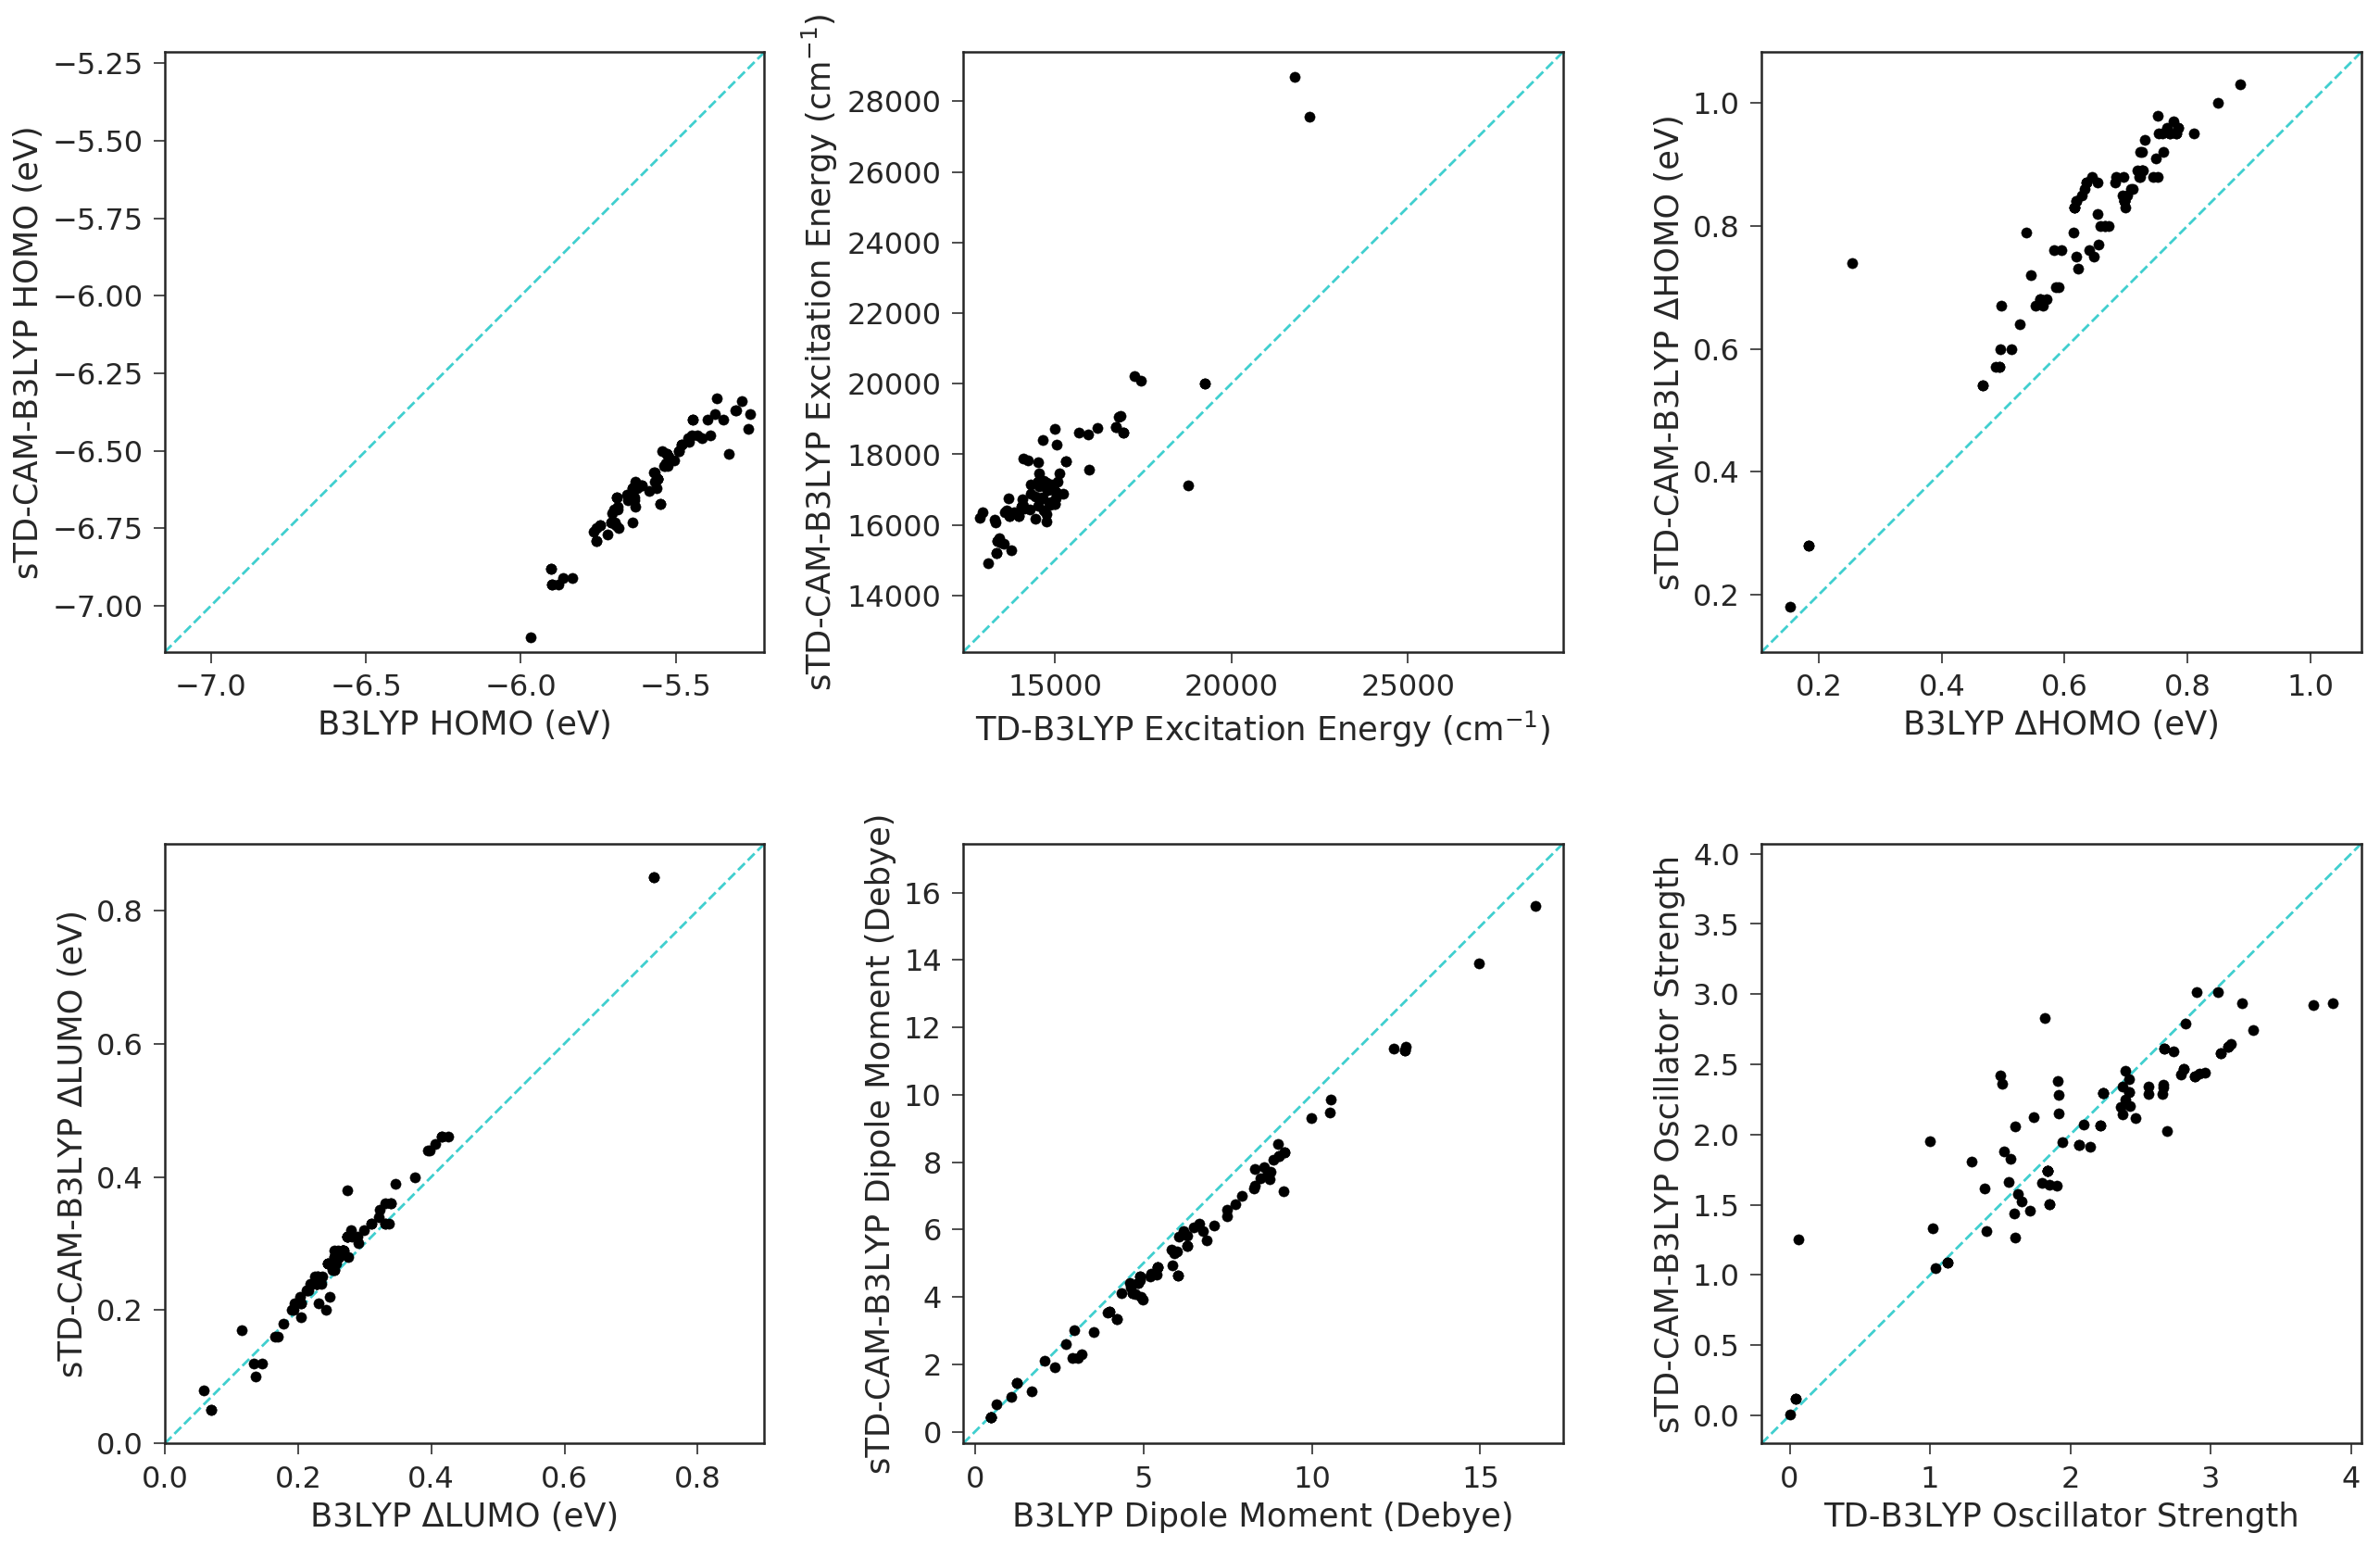

In [75]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (18, 12))

scatterplot_bigfig('AccHOMO', 'sTDDFTHOMO', df, 'B3LYP HOMO (eV)', 'sTD-CAM-B3LYP HOMO (eV)', xyline=True, ax = ax1)
scatterplot_bigfig('acc_lowest_transition_wavenumber', 'sTDDFTacclowestengtranswavenumber', df,'TD-B3LYP Excitation Energy ($\mathregular{cm^{-1}}$)', 'sTD-CAM-B3LYP Excitation Energy ($\mathregular{cm^{-1}}$)', xyline=True, ax = ax2)
scatterplot_bigfig('AccDeltaHOMO', 'sTDDFTdeltaHOMO', df,'B3LYP \u0394HOMO (eV)', 'sTD-CAM-B3LYP \u0394HOMO (eV)', xyline=True, ax=ax3)
scatterplot_bigfig('AccDeltaLUMO', 'sTDDFTdeltaLUMO', df,'B3LYP \u0394LUMO (eV)', 'sTD-CAM-B3LYP \u0394LUMO (eV)', xyline=True, ax=ax4)
scatterplot_bigfig('GSDipMom', 'sTDDFTdipolemoment', df,'B3LYP Dipole Moment (Debye)', 'sTD-CAM-B3LYP Dipole Moment (Debye)', xyline=True, ax=ax5)
scatterplot_bigfig('acc_highest_oscs_under_ten', 'sTDDFTacchighestoscsunderten', df,'TD-B3LYP Oscillator Strength', 'sTD-CAM-B3LYP Oscillator Strength', xyline=True, ax=ax6)

plt.subplots_adjust(top = 0.93, wspace = 0.3, hspace = 0.4)
plt.tight_layout()
plt.savefig('../figures/DFT_vs_sTDDFT.pdf')
plt.savefig('../figures/DFT_vs_sTDDFT.png', dpi = 300)
plt.show()